<h1>Advanced Lane Finding Project</h1>

The goals / steps of this project are the following:

<ol>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.</li>
<li>Apply a distortion correction to raw images.</li>
<li>Use color transforms, gradients, etc., to create a thresholded binary image.</li>
<li>Apply a perspective transform to rectify binary image ("birds-eye view").</li>
<li>Detect lane pixels and fit to find the lane boundary.</li>
<li>Determine the curvature of the lane and vehicle position with respect to center.</li>
<li>Warp the detected lane boundaries back onto the original image.</li>
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.</li>
</ol>

<h1>All required imports</h1>

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

<h1>1. Camera Calibration</h1>

In [8]:

def calibrate( images ) :
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        if gray.shape != (720,1280) :
            print( fname, gray.shape )

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True :
            objpoints.append(objp)
            imgpoints.append(corners)
        else :
            print( "findChessboardCorners ERROR on:", fname )
            
        #Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #print( fname )
        #plt.imshow(img)
        #plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print( mtx )
    print( dist )
    
    return mtx, dist

In [9]:
mtx, dist = calibrate( glob.glob('../camera_cal/calibration*.jpg') )
print( mtx, dist )

findChessboardCorners ERROR on: ../camera_cal/calibration4.jpg
../camera_cal/calibration7.jpg (721, 1281)
findChessboardCorners ERROR on: ../camera_cal/calibration1.jpg
findChessboardCorners ERROR on: ../camera_cal/calibration5.jpg
../camera_cal/calibration15.jpg (721, 1281)
[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]
[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


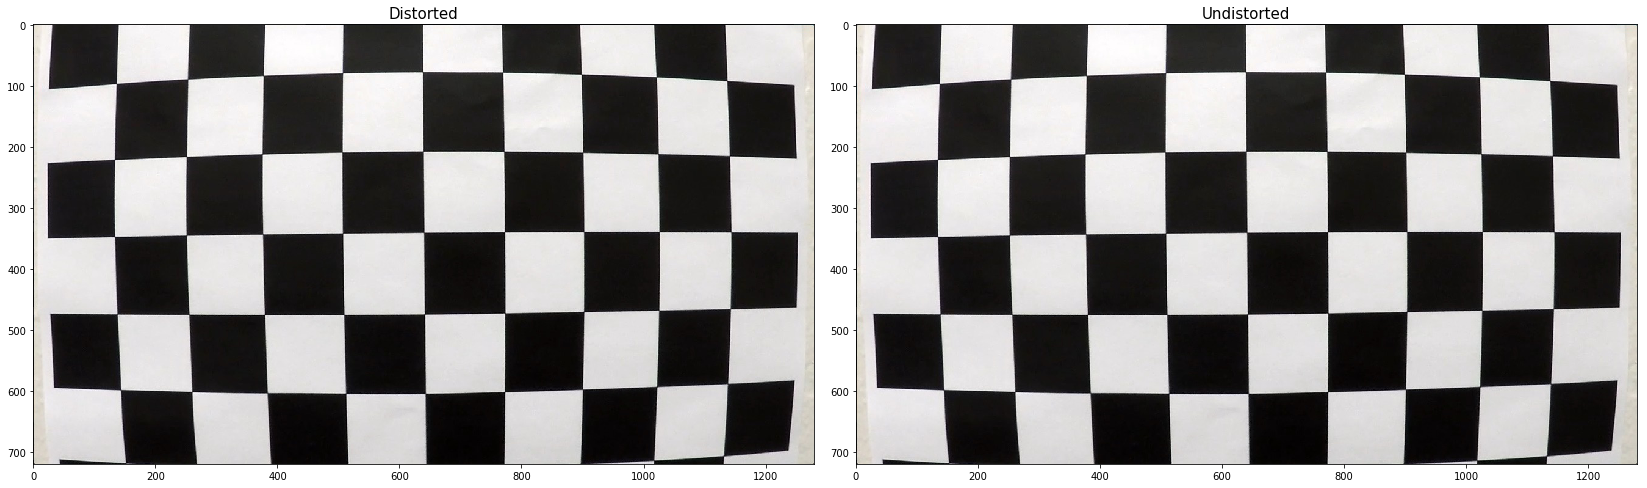

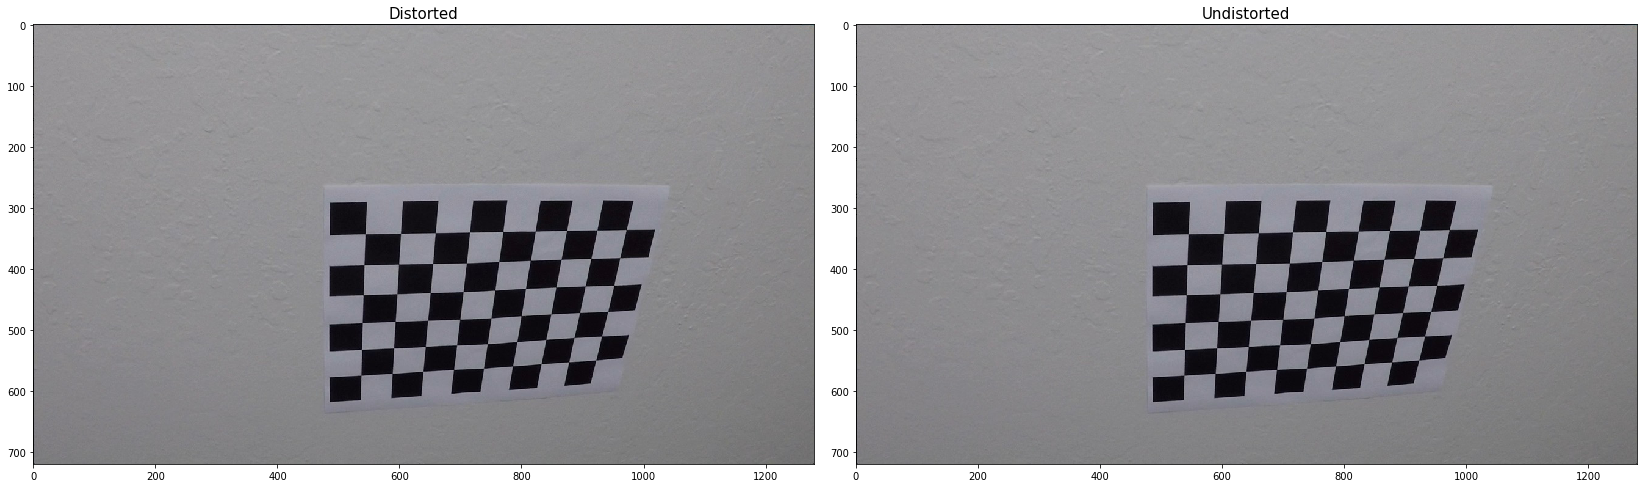

In [10]:
calibration_images = sorted( glob.glob('../camera_cal/calibration*.jpg') )

for i in range(0, 2):
    fname = calibration_images[i]
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    img_undist = cv2.undistort( img, mtx, dist )

    f, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(23, 19))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title( 'Distorted', fontsize=15)    
    ax2.imshow(img, cmap='gray')
    
    ax2.set_title('Undistorted', fontsize=15)
    ax2.imshow(img, cmap='gray')


<h1>2. Helper functions</h1>

In [11]:
### helpers 


solbel_kernel=7
# 170
# 200
def hsv_select_v( img, threshold=(181,255) ) :
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    V = hsv[:,:,2]
    Vtresholded = np.zeros_like(V)
    Vtresholded[(V > threshold[0]) & (V <= threshold[1])] = 255
    return Vtresholded
    

### re-used from 7.11
def hls_select(img, thresh=(89, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

### re-used from 7.8
# Define a function that takes an image, gradient orientation, and threshold min / max values.
def sobel_abs_threshold(img, orient='x', kernel=solbel_kernel, thresh=( 20, 255 ) ):
    # Convert to grayscale    
    if len(img.shape)==3 :
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def sobel_mag_threshold(img, kernel=solbel_kernel, mag_thresh=(30, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    if len(img.shape)==3 :
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # 3) Calculate the magnitude
    abs_sobelxy = np.sqrt( np.power(sobel_x,2)+np.power(sobel_y,2) )
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def sobel_dir_threshold(img, kernel=solbel_kernel, thresh=(-0.5, 0.5)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    if len(img.shape)==3 :
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad_sobel=np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(dir_grad_sobel >= thresh[0]) & (dir_grad_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def perspective_transform( image, top, coffs, reverse=False, verbose=False ) :                    
    src = np.float32( [ [ 200, 690 ],
                        [ 640-coffs, top ],
                        [ 640+coffs, top ],
                        [ 1100, 690 ] ] )
    
    if verbose:
        print("transform src:")
        image_copy = np.zeros((720,1280,3), dtype='uint8')
        #image_copy[:,:,0] = image.copy()
        #image_copy[:,:,1] = image.copy()
        #image_copy[:,:,2] = image.copy()
        image_copy[ image != 0 ]=(255,255,255)
        for i in [0,1,2]:
            cv2.line( image_copy, (src[i][0], src[i][1]),(src[i+1][0],src[i+1][1]),          (255,0,0), 3 )
        plt.imshow(image_copy)
        plt.show()
    
    img_size = (image.shape[1], image.shape[0])
    
    dst = np.float32([[220, 720], 
                      [220, 0],
                      [1070, 0],
                      [1070, 720]])
    
    if reverse == False:
        M = cv2.getPerspectiveTransform(src, dst)    
        image = cv2.warpPerspective( image, M, img_size, flags=cv2.INTER_NEAREST  )
    else :
        invM = cv2.getPerspectiveTransform(dst, src)
        image = cv2.warpPerspective(image, invM, img_size)
    
    if verbose:
        print("transform dst:")
        image_copy = np.zeros((720,1280,3), dtype='uint8')
        image_copy[ image != 0 ]=(255,255,255)
        cv2.line( image_copy, (dst[0][0], 720),(dst[0][0],0),          (255,0,0), 3 )
        cv2.line( image_copy, (dst[2][0], 720),(dst[2][0],0),          (255,0,0), 3 )        
        plt.imshow(image_copy)
        plt.show()
        
    return image

###############################################################################################################

def find_lane_pixels( binary_warped ):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = np.zeros((720,1280,3), dtype='uint8')
    out_img[ binary_warped>0 ]=(255,255,255)
    #cv2.line( out_img, (0, 720),(1280,0),          (255,0,0), 3 )
    #plt.imshow(out_img)
    #plt.show()
    #print( out_img.shape, type(out_img) )
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 250

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int((binary_warped.shape[0]) // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (255, 255, 0), 2)
        
        #plt.imshow(out_img)
        #plt.show()
        
        #nzl =  binary_warped[win_y_low:win_y_high, win_xleft_low:win_xleft_high].nonzero()
        #nzr =  binary_warped[win_y_low:win_y_high, win_xright_low:win_xright_high].nonzero()

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds =  ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &  (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) ).nonzero()[0]
        good_right_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox>=win_xright_low) & (nonzerox<win_xright_high ) ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len( good_left_inds ) > minpix :
            #print( "good left:", len( good_left_inds ) )
            leftx_current = np.int(np.mean( nonzerox[good_left_inds] ))
        if len( good_right_inds ) > minpix :
            #print( "good right:", len( good_right_inds ) )
            rightx_current = np.int(np.mean( nonzerox[good_right_inds] ))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print( 'error' )
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #print( left_lane_inds, right_lane_inds )
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, verbose=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    if len(leftx) > 0 : 
        ### Fit a second order polynomial to each using `np.polyfit` ###
        left_fit  = np.polyfit(lefty,  leftx,  2)
    else:
        left_fit=[0,0,1]
        
    if len(rightx>0) : 
        ### Fit a second order polynomial to each using `np.polyfit` ###
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = [0,0,1]
    
    #print( left_fit )
    #print( right_fit )
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines    
    draw_points_l = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
    draw_points_r = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
    
    if verbose == True :
        cv2.polylines(out_img, [draw_points_l], False, (255,63,0), thickness=25 )
        cv2.polylines(out_img, [draw_points_r], False, (0,255,255), thickness=25 )
        plt.imshow( out_img )
        plt.show()
    
    #plt.plot(left_fitx, ploty, color='yellow')
    
    #print( draw_points_l.shape )
    #print( draw_points_r )
    
    out_img = np.zeros((720,1280,3), dtype='uint8')
    cv2.fillPoly( out_img, [ np.concatenate( (draw_points_l, np.flip(draw_points_r,0) ) ) ], (0,127,0) ) 
    cv2.polylines(out_img, [draw_points_l], False, (255,200,0), thickness=25 )
    cv2.polylines(out_img, [draw_points_r], False, (0,200,255), thickness=25 )
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    #print(leftx)
    
    if len(leftx)>0 :
        left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    else: 
        left_fit = [0.001,0,1]
        
    if len( rightx)>0:
        right_fit = np.polyfit(righty*ym_per_pix, rightx * xm_per_pix, 2)
    else:
        right_fit=[0.001,0,1]
    
    y=binary_warped.shape[0]-1
    # print( y, left_fit, right_fit )
    
    left_curverad = (( 1 + (2*left_fit[0]*y*ym_per_pix+left_fit[1])**2 )**1.5)/abs(2*left_fit[0]) ## Implement the calculation of the left line here
    right_curverad =(( 1 + (2*right_fit[0]*y*ym_per_pix+right_fit[1])**2)**1.5)/abs(2*right_fit[0])   ## Implement the calculation of the right line here
    
    left_pos  = left_fit[0]*y*ym_per_pix*y*ym_per_pix + left_fit[1]*y*ym_per_pix + left_fit[2] - (640.0 * xm_per_pix )
    right_pos = right_fit[0]*y*ym_per_pix*y*ym_per_pix + right_fit[1]*y*ym_per_pix + right_fit[2] - (640.0 * xm_per_pix )
    
    if MORE_VERBOSITY==True:
        print( "DEBUG:", left_curverad, right_curverad, left_pos, right_pos )
    
    return out_img, (left_curverad + right_curverad)/2.0, left_pos+right_pos


<h1>3. Define pipeline. Image processor</h1>

In [14]:
class processor:
    def __init__( self, mtx, dist, case_number, verbose=False ):
        self.verbose = verbose
        self.MORE_VERBOSITY = verbose
        
        self.mtx = mtx
        self.dist = dist
        
        self.case_number = case_number
        
        if case_number == 2 :
            self.v_treshold=171
            self.pers_trans_top = 525
            self.pers_trans_coffs = 160
        else:
            self.v_treshold=201
            self.pers_trans_top = 470
            self.pers_trans_coffs = 90 
            
        self.reset()
        
    def reset( self ) :
        #self.leftx = []
        #self.lefty = []
        #self.rightx = [] 
        #self.righty = []
        
        self.left_fit = []
        self.right_fit = []
    
        self.curvature = None
        self.offset = None
    
    
    def calculate_curvature_and_offset(self, leftx, lefty, rightx, righty ) :
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
        
        if len(leftx)>0 and len(rightx)>0 :
            left_fit  = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
            right_fit = np.polyfit(righty*ym_per_pix, rightx * xm_per_pix, 2)
            
            y=720-1

            left_curverad = (( 1 + (2*left_fit[0]*y*ym_per_pix+left_fit[1])**2 )**1.5)/abs(2*left_fit[0]) ## Implement the calculation of the left line here
            right_curverad =(( 1 + (2*right_fit[0]*y*ym_per_pix+right_fit[1])**2)**1.5)/abs(2*right_fit[0])   ## Implement the calculation of the right line here

            left_pos  = left_fit[0]*y*ym_per_pix*y*ym_per_pix + left_fit[1]*y*ym_per_pix + left_fit[2] - (640.0 * xm_per_pix )
            right_pos = right_fit[0]*y*ym_per_pix*y*ym_per_pix + right_fit[1]*y*ym_per_pix + right_fit[2] - (640.0 * xm_per_pix )

            if self.MORE_VERBOSITY == True:
                print( "DEBUG:Cl={0:.3f} Cr={1:.3f} ratio={2:.3f} Pl={3:.2f} Pr={4:.2f}".format( 
                                    left_curverad, 
                                    right_curverad, 
                                    left_curverad/right_curverad, 
                                    left_pos, 
                                    right_pos )
                )
                
            curvature = (left_curverad + right_curverad)/2.0
            offset = left_pos+right_pos
        else:
            curvature = None
            offset = None 
            
        return curvature, offset
    
    
    def fit_poly( self, leftx, lefty, rightx, righty, h=720 ) :
        
        ### Fit a second order polynomial to each with np.polyfit() ###
        ### Generate x and y values for plotting
        ploty = np.linspace(0, h - 1, h)
        ### Calc both polynomials using ploty, left_fit and right_fit ###
        if len(leftx) > 0:
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        else:
            left_fit = []
            left_fitx = []
            
        if len(rightx) > 0:
            right_fit = np.polyfit(righty, rightx, 2)
            right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
        else:
            right_fit = []
            right_fitx = []
            

        return left_fitx, right_fitx, ploty
    
    def search_around_poly(self, binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 75

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy +
                        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) +
                        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy +
                        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) +
                        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        #print("128:", len(leftx), len(lefty) )
        
        # Fit new polynomials
        left_fitx, right_fitx, ploty = self.fit_poly( leftx, lefty, rightx, righty )
        
        #print("133:", len(left_fitx), len(right_fitx) )
        
        
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        #out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        out_img = np.zeros((720,1280,3), dtype='uint8')
        out_img[ binary_warped>0 ]=(255,255,255)
        window_img = np.zeros_like(out_img)

        if len(left_fitx)>0 and len(right_fitx)>0:
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin,
                                                                            ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin,
                                                                             ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

            # Plot the polynomial lines onto the image
            #plt.plot(left_fitx, ploty, color='yellow')
            #plt.plot(right_fitx, ploty, color='yellow')
            ## End visualization steps ##
        else:
            leftx = []
            lefty = []
            rightx = []
            righty = []
            
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        return leftx, lefty, rightx, righty, result
    
    
    def __call__(self, image, index=-1 ) :
        
        detected_shit = False
        
        input_image = image.copy() 
        
        #if self.verbose == True:
        #    print("input image:")
        #    plt.imshow( image )
        #    plt.show()
            
        image = cv2.undistort( image, self.mtx, self.dist )

        if self.verbose == True:
            print("undistorted:")
            plt.imshow( image )
            plt.show()
            
        image_sel = hsv_select_v( image, threshold=(self.v_treshold,255) )
        
        if self.case_number == 1 and np.mean( image[ image_sel.shape[0]//2:,:] ) > 20 :
            image_sel = hsv_select_v( image, threshold=(220,255) )
        
        image = image_sel
        
        if self.verbose == True and self.MORE_VERBOSITY:
            
            print("HSV only V")
            plt.imshow( image, cmap='gray' )
            plt.show()

        # Apply each of the sobel thresholding functions
        img_gradx = sobel_abs_threshold(image, orient='x')

        if self.verbose == True and self.MORE_VERBOSITY:
            print("sobel abs x")
            plt.imshow( img_gradx, cmap='gray' )
            plt.show()

        img_grady = sobel_abs_threshold(image, orient='y')

        if self.verbose == True and self.MORE_VERBOSITY:
            print("sobel abs y")
            plt.imshow( img_grady, cmap='gray' )
            plt.show()

        img_mag_binary = sobel_mag_threshold(image)

        if self.verbose == True and self.MORE_VERBOSITY:
            print("sobel mag")
            plt.imshow( img_mag_binary, cmap='gray' )
            plt.show()

        img_dir_binary = sobel_dir_threshold(image)

        if self.verbose == True and self.MORE_VERBOSITY:
            print("sobel dir")
            plt.imshow( img_dir_binary, cmap='gray' )
            plt.show()

        #img_combined = np.zeros_like(img_dir_binary)
        img_combined = np.zeros( (input_image.shape[0],input_image.shape[1]) )    
        img_combined[ (image==1) | ((img_gradx == 1) & (img_grady == 1)) | ((img_mag_binary == 1) & (img_dir_binary == 0)) ] = 1

        if self.verbose == True:
            print("combined")
            plt.imshow( img_combined, cmap='gray' )
            plt.show()
            
        img_transformed = perspective_transform( img_combined, 
                                                top = self.pers_trans_top,
                                                coffs = self.pers_trans_coffs,
                                                verbose=self.verbose )

        #if self.verbose == True:
        #    print("transformed")
        #    plt.imshow( img_transformed, cmap='gray' )
        #    plt.show()
        
        if len( self.left_fit ) == 0 and len( self.right_fit ) == 0 :            
            # Find our lane pixels first
            new_leftx, new_lefty, new_rightx, new_righty, out_img = find_lane_pixels( img_transformed )
        else:
            new_leftx, new_lefty, new_rightx, new_righty, out_img = self.search_around_poly( img_transformed )

        #print("259:", len(new_leftx), len(new_rightx) )
        
        curvature, offset = self.calculate_curvature_and_offset( new_leftx, new_lefty, new_rightx, new_righty )
        
        if offset is not None and np.absolute( offset ) < 3.7 :        
            if len(new_leftx) > 0:
                new_left_fit = np.polyfit(new_lefty,  new_leftx,  2)
            else:
                new_left_fit = []
            if len( new_rightx )>0:
                new_right_fit = np.polyfit(new_righty, new_rightx, 2)
            else:
                new_right_fit = [] 

            if self.verbose == True:
                print(  new_left_fit, new_right_fit)
                print( self.left_fit, self.right_fit )

            if ( len( self.left_fit ) == 0 and len( self.right_fit ) == 0 ) or ( self.case_number == 1 ) :            
                self.left_fit = new_left_fit
                self.right_fit = new_right_fit
            else:
                if len(new_left_fit)==3:
                    # print( "284:", new_left_fit [2])
                    if np.absolute( self.left_fit[2] - new_left_fit[2] ) < self.left_fit[2]*0.05 :
                        self.left_fit = np.mean( [self.left_fit, new_left_fit], axis=0 )
                    else:
                        print('left out of bound')
                else:
                    print('left has not detected' )

                if len(new_right_fit)==3:
                    # print( "293:", new_right_fit [2])
                    if np.absolute( self.right_fit[2] - new_right_fit[2] ) < self.right_fit[2]*0.1 : 
                        self.right_fit = np.mean( [self.right_fit, new_right_fit], axis=0 )
                    else:
                        print('right out of bound')
                else:
                    print('right has not detected' )

                #self.left_fit = new_left_fit
                #self.right_fit = new_right_fit
        else:
            print('offset out of boud')

        ploty = np.linspace(0, 720 - 1, 720)        
        try:
            left_fitx = self.left_fit[0] * ploty ** 2 + self.left_fit[1] * ploty + self.left_fit[2]
            right_fitx = self.right_fit[0] * ploty ** 2 + self.right_fit[1] * ploty + self.right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1 * ploty ** 2 + 1 * ploty
            right_fitx = 1 * ploty ** 2 + 1 * ploty

        # Plots the left and right polynomials on the lane lines    
        draw_points_l = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
        draw_points_r = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
                
        if self.verbose == True:
            print("find_lane_pixels:")
            ## Visualization ##
            # Colors in the left and right lane regions
            out_img[new_lefty, new_leftx] = [255, 0, 0]
            out_img[new_righty, new_rightx] = [0, 0, 255]
            
            cv2.polylines(out_img, [draw_points_l], False, (255,220,0), thickness=5 )
            cv2.polylines(out_img, [draw_points_r], False, (0,220,255), thickness=5 )
            
            plt.imshow( out_img )
            plt.show()
                
        lanes = np.zeros((720,1280,3), dtype='uint8')
        
        cv2.fillPoly( lanes, [ np.concatenate( (draw_points_l, np.flip(draw_points_r,0) ) ) ], (0,127,0) ) 
        
        lanes = perspective_transform( lanes, top=self.pers_trans_top, coffs = self.pers_trans_coffs, reverse=True )
    
        result_image = cv2.addWeighted( input_image, 1.0, lanes, 0.3, 0)
        
        if curvature is not None :
            if self.curvature is not None :
                self.curvature = ( self.curvature + curvature ) / 2.0
            else:
                self.curvature = curvature
                
        if offset is not None :
            if self.offset is not None :                
                self.offset = ( self.offset + offset ) / 2.0
            else:
                self.offset = offset 
        
        message = "Radius of Curvature = {0:.2f}(m)".format(self.curvature)
        cv2.putText(result_image, message, (40,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3 )
        message = "Vehicle offset is {0:.3f} m".format(self.offset)
        cv2.putText(result_image, message, (40,90), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3 )
        
        if index != -1 :
            message = "Frame {0:4d}".format(index+1)
            cv2.putText(result_image, message, (40,130), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3 )        
        
        return result_image

        

undistorted:


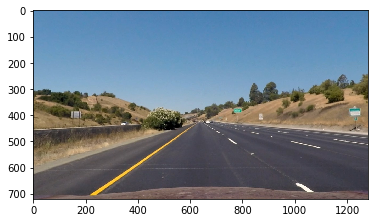

HSV only V


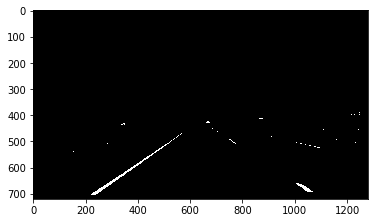

sobel abs x


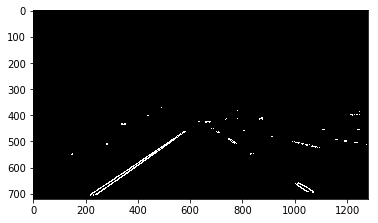

sobel abs y


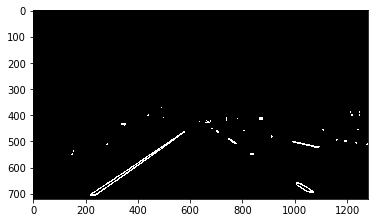

sobel mag


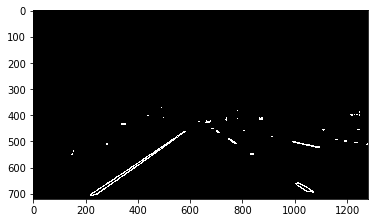

sobel dir


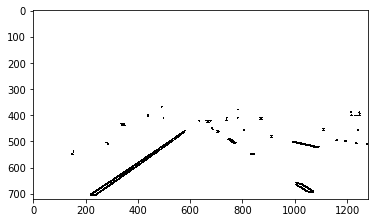

combined


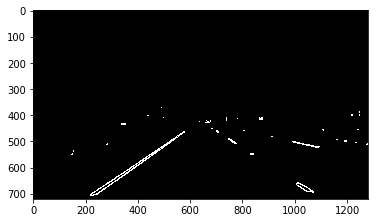

transform src:


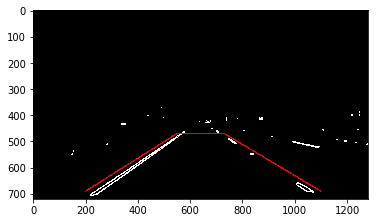

transform dst:


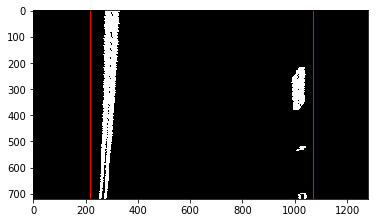

DEBUG:Cl=4305.193 Cr=830.905 ratio=5.181 Pl=-1.98 Pr=2.08
[ -3.81515822e-05  -2.16485408e-02   3.01491115e+02] [  1.97725336e-04  -1.56960140e-01   1.04437323e+03]
[] []
find_lane_pixels:


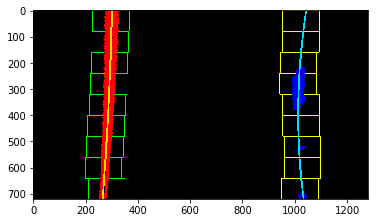

../test_images/straight_lines1.jpg


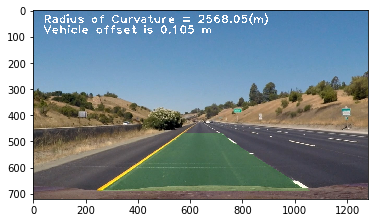

In [16]:
images = sorted( glob.glob('../test_images/*.jpg') )

for i in range( 0, 1 ) :
    p = processor( mtx=mtx, dist=dist, case_number=1, verbose=True )
    fname = images[i]
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = p( img )
    # if r == True:
    print( fname )
    plt.imshow(img)
    plt.show()

In [ ]:
#mtx, dist = calibrate( glob.glob('../camera_cal/calibration*.jpg') )

p = processor( mtx=mtx, dist=dist, case_number=1, verbose=False )
    
images = sorted( glob.glob('../input_images/001/*.jpg') )


for i in range( 619, 620 ) :
    fname = images[i]
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = p( img, index=i )
    # if r == True:
    print( fname )
    plt.imshow(img)
    plt.show()

In [ ]:
#mtx, dist = calibrate( glob.glob('../camera_cal/calibration*.jpg') )

p = processor( mtx=mtx, dist=dist, case_number=2, verbose=False )
    
#images = sorted( glob.glob('../test_images/*.jpg') )
images = sorted( glob.glob('../input_images/ch1/*.jpg') )
# np.random.random_integers( 0, len(images), 2 )

for i in range(0,1 ) :
    fname = images[i]
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) ### WTF
    img = p( img, index=i )
    # if r == True:
    print( fname )
    plt.imshow(img)
    plt.show()

In [ ]:
images = [ '../test_images/test2.jpg',
           '../input_images/ch1/016.jpg', 
           '../input_images/ch1/022.jpg']

# Make a list of images
# images = sorted( glob.glob('../test_images/*.jpg') )
#images = sorted( glob.glob('../input_images/001/*.jpg') )
images = sorted( glob.glob('../input_images/ch1/*.jpg') )
# print( images )
# Step through the list and search for chessboard corners


if False:
    for i in range( 984, 1037 ):
        fname = images[i]

        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) ### WTF
        
        #lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        #plt.imshow(lab)
        #plt.show()
        #l, a, b = cv2.split(lab)
        #plt.imshow( l, cmap='gray')
        #plt.show()
        #plt.imshow( a, cmap='gray')
        #plt.show()
        #plt.imshow( b, cmap='gray')
        #plt.show()
        #print( i, fname )

        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H = hls[:,:,0]
        S = hls[:,:,1]
        V = hls[:,:,2]

        #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        f, (ax1, ax2, ax3, ax4 ) = plt.subplots(1, 4, figsize=(19, 17))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title(fname, fontsize=15)    
        ax2.imshow(H, cmap='gray')
        ax2.set_title('HSV ->H', fontsize=15)
        ax3.imshow(S, cmap='gray')
        ax3.set_title('HSV ->S', fontsize=15)
        ax4.imshow(V, cmap='gray')
        ax4.set_title('HSV ->V', fontsize=15)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
if True:
    for i in range( 106, 110 ):
        fname = images[i]

        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) ### WTF

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        V = hsv[:,:,2]
        
        
        Vb200 = np.zeros_like(V)
        Vb200[ V > 200 ] = 1
        
        Vb190 = np.zeros_like(V)
        Vb190[ V > 190 ] = 1
        
        Vb180 = np.zeros_like(V)
        Vb180[ V > 180 ] = 1
        
        Vb170 = np.zeros_like(V)
        Vb170[ V > 170 ] = 1
        
        Vb160 = np.zeros_like(V)
        Vb160[ V > 165 ] = 1

        #SV = cv2.bitwise_or(Vb,Sb)
        
        f, (ax1, ax2, ax3, ax31, ax4, ax41, ax5 ) = plt.subplots(1, 7, figsize=(13, 11))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title(fname, fontsize=15)    
        ax2.imshow(V, cmap='gray')
        ax2.set_title('HSV -> V', fontsize=15)
        
        ax3.imshow(Vb200, cmap='gray')
        ax3.set_title('HSV -> V [200..]', fontsize=15)
        
        ax31.imshow(Vb190, cmap='gray')
        ax31.set_title('HSV -> V [190..]', fontsize=15)
        
        ax4.imshow(Vb180, cmap='gray')
        ax4.set_title('HSV -> V [180..]', fontsize=15)

        ax41.imshow(Vb170, cmap='gray')
        ax41.set_title('HSV -> V [170..]', fontsize=15)
        
        ax5.imshow(Vb160, cmap='gray')
        ax5.set_title('HSV -> V [160..]', fontsize=15)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        

In [ ]:
images = [  
            '../input_images/ch1/0132.jpg',
            '../input_images/ch1/0133.jpg',
            '../test_images/test2.jpg'
        ]

# Make a list of images
# images = sorted( glob.glob('../test_images/*.jpg') )

images = sorted( glob.glob('../input_images/001/*.jpg') )
#images = sorted( glob.glob('../input_images/ch1/*.jpg') )
#images = []
# 611, 612, 613, 

for i in np.random.randint(0,len(images),(1,)):
    fname = images[i]
    print(i, fname)
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) ### WTF
    #print( img.shape, type(img) )
    result = process_image( in_img=img, in_index=i, in_verbose=False )
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow( img )
    ax1.set_title(fname, fontsize=50)
    ax2.imshow(result)
    ax2.set_title( 'out:', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [ ]:
def process_dir( dir_name ):
    p = processor( mtx=mtx, dist=dist, verbose=False )
    images_pd = sorted( glob.glob('../input_images/' + dir_name + '/*.jpg') )    
    for i in range( 0, len(images_pd) ) :
        fname_pd = images_pd[i]
        print( i, fname_pd )
        img_pd = cv2.imread(fname_pd)
        img_pd = cv2.cvtColor(img_pd, cv2.COLOR_RGB2BGR)
        #plt.imshow( img_pd )
        #plt.show()
        result_pd = p( img_pd )
        #plt.imshow( result_pd )
        #plt.show()
        result_ = cv2.cvtColor(result_pd, cv2.COLOR_BGR2RGB)
        cv2.imwrite('../output_images/' + dir_name + '/{0:04d}.jpg'.format(i+1), result_)
        

In [ ]:
#process_dir( '001' )
process_dir( 'ch1' )
#process_dir( 'ch3' )

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
processor_instance = processor( mtx=mtx, dist=dist, case_number=1, verbose=False )

white_output = '../output_videos/01_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image( processor_instance ) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/01_project_video.mp4
[MoviePy] Writing video ../output_videos/01_project_video.mp4


 83%|████████▎ | 1047/1261 [05:34<01:08,  3.13it/s]

offset out of boud


 83%|████████▎ | 1048/1261 [05:35<01:08,  3.10it/s]

offset out of boud


 83%|████████▎ | 1049/1261 [05:35<01:09,  3.06it/s]

offset out of boud


 83%|████████▎ | 1050/1261 [05:35<01:09,  3.05it/s]

offset out of boud


 83%|████████▎ | 1052/1261 [05:36<01:08,  3.05it/s]

offset out of boud


100%|█████████▉| 1260/1261 [06:44<00:00,  3.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/01_project_video.mp4 

CPU times: user 4min 28s, sys: 14.4 s, total: 4min 42s
Wall time: 6min 47s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [20]:
processor_instance = processor( mtx=mtx, dist=dist, case_number=2, verbose=False )

white_output = '../output_videos/02_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image( processor_instance ) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/02_challenge_video.mp4
[MoviePy] Writing video ../output_videos/02_challenge_video.mp4


  1%|          | 5/485 [00:01<02:02,  3.92it/s]

right out of bound


  1%|          | 6/485 [00:01<01:59,  4.01it/s]

right out of bound


 26%|██▋       | 128/485 [00:35<01:43,  3.46it/s]

left out of bound


 27%|██▋       | 130/485 [00:35<01:44,  3.41it/s]

left out of bound
right out of bound


 27%|██▋       | 131/485 [00:36<01:41,  3.50it/s]

left out of bound


 27%|██▋       | 132/485 [00:36<01:43,  3.42it/s]

left out of bound
right out of bound


 27%|██▋       | 133/485 [00:36<01:40,  3.49it/s]

offset out of boud


 28%|██▊       | 134/485 [00:37<01:38,  3.55it/s]

offset out of boud


 28%|██▊       | 135/485 [00:37<01:41,  3.43it/s]

offset out of boud


 28%|██▊       | 136/485 [00:37<01:37,  3.58it/s]

offset out of boud


 28%|██▊       | 137/485 [00:37<01:38,  3.55it/s]

offset out of boud


 28%|██▊       | 138/485 [00:38<01:36,  3.59it/s]

offset out of boud


 29%|██▊       | 139/485 [00:38<01:39,  3.49it/s]

offset out of boud


 29%|██▉       | 140/485 [00:38<01:35,  3.62it/s]

offset out of boud


 29%|██▉       | 141/485 [00:39<01:38,  3.51it/s]

offset out of boud


 29%|██▉       | 142/485 [00:39<01:34,  3.63it/s]

offset out of boud


 29%|██▉       | 143/485 [00:39<01:38,  3.49it/s]

offset out of boud


 30%|██▉       | 144/485 [00:39<01:34,  3.62it/s]

offset out of boud


 30%|██▉       | 145/485 [00:40<01:35,  3.54it/s]

offset out of boud


 30%|███       | 146/485 [00:40<01:36,  3.50it/s]

offset out of boud


 30%|███       | 147/485 [00:40<01:34,  3.56it/s]

offset out of boud


 31%|███       | 148/485 [00:40<01:35,  3.53it/s]

offset out of boud


 31%|███       | 149/485 [00:41<01:38,  3.43it/s]

offset out of boud


 31%|███       | 150/485 [00:41<01:38,  3.41it/s]

offset out of boud


 31%|███       | 151/485 [00:41<01:40,  3.32it/s]

offset out of boud


 31%|███▏      | 152/485 [00:42<01:41,  3.29it/s]

offset out of boud


 32%|███▏      | 153/485 [00:42<01:40,  3.31it/s]

right out of bound


 32%|███▏      | 154/485 [00:42<01:41,  3.27it/s]

right out of bound


 32%|███▏      | 155/485 [00:43<01:43,  3.20it/s]

right out of bound


 32%|███▏      | 156/485 [00:43<01:45,  3.12it/s]

right out of bound


 33%|███▎      | 159/485 [00:44<01:45,  3.09it/s]

right out of bound


 33%|███▎      | 160/485 [00:44<01:47,  3.01it/s]

right out of bound


 33%|███▎      | 161/485 [00:45<01:46,  3.04it/s]

right out of bound


 33%|███▎      | 162/485 [00:45<01:44,  3.10it/s]

right out of bound


 34%|███▎      | 163/485 [00:45<01:45,  3.05it/s]

offset out of boud


 34%|███▍      | 164/485 [00:46<01:42,  3.12it/s]

right out of bound


 35%|███▌      | 171/485 [00:48<01:40,  3.12it/s]

right out of bound


 53%|█████▎    | 256/485 [01:14<01:09,  3.29it/s]

right out of bound


 82%|████████▏ | 399/485 [01:57<00:25,  3.40it/s]

left out of bound


 93%|█████████▎| 450/485 [02:12<00:10,  3.27it/s]

right out of bound


 96%|█████████▌| 464/485 [02:17<00:06,  3.22it/s]

right out of bound


100%|██████████| 485/485 [02:23<00:00,  3.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/02_challenge_video.mp4 

CPU times: user 1min 33s, sys: 5.59 s, total: 1min 39s
Wall time: 2min 26s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
processor_instance = processor( mtx=mtx, dist=dist, case_number=2, verbose=False )

white_output = '../output_videos/03_harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../harder_challenge_video.mp4")
white_clip = clip1.fl_image( processor_instance ) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_videos/03_harder_challenge_video.mp4
[MoviePy] Writing video ../output_videos/03_harder_challenge_video.mp4


  0%|          | 5/1200 [00:01<05:53,  3.38it/s]

left out of bound


  0%|          | 6/1200 [00:01<05:40,  3.50it/s]

left out of bound


  1%|          | 7/1200 [00:02<05:27,  3.65it/s]

left out of bound


  1%|          | 12/1200 [00:03<05:27,  3.62it/s]

left out of bound


  1%|          | 13/1200 [00:03<05:20,  3.70it/s]

left out of bound


  1%|▏         | 15/1200 [00:04<05:27,  3.61it/s]

left out of bound


  1%|▏         | 16/1200 [00:04<05:18,  3.71it/s]

left out of bound


  1%|▏         | 17/1200 [00:04<05:32,  3.56it/s]

left out of bound


  2%|▏         | 18/1200 [00:05<05:26,  3.63it/s]

left out of bound


  2%|▏         | 19/1200 [00:05<05:17,  3.72it/s]

left out of bound


  2%|▏         | 20/1200 [00:05<05:29,  3.58it/s]

left out of bound


  2%|▏         | 21/1200 [00:05<05:22,  3.66it/s]

left out of bound


  2%|▏         | 22/1200 [00:06<05:14,  3.74it/s]

left out of bound


  2%|▏         | 23/1200 [00:06<05:28,  3.58it/s]

left out of bound


  2%|▏         | 24/1200 [00:06<05:21,  3.66it/s]

left out of bound


  2%|▏         | 25/1200 [00:06<05:12,  3.76it/s]

left out of bound


  2%|▏         | 26/1200 [00:07<05:26,  3.59it/s]

left out of bound


  2%|▏         | 27/1200 [00:07<05:21,  3.65it/s]

left out of bound


  2%|▏         | 28/1200 [00:07<05:12,  3.76it/s]

left out of bound


  2%|▏         | 29/1200 [00:08<05:29,  3.56it/s]

left out of bound


  2%|▎         | 30/1200 [00:08<05:24,  3.61it/s]

left out of bound


  3%|▎         | 31/1200 [00:08<05:15,  3.71it/s]

left out of bound


  3%|▎         | 32/1200 [00:08<05:28,  3.56it/s]

left out of bound


  3%|▎         | 33/1200 [00:09<05:21,  3.63it/s]

left out of bound


  3%|▎         | 34/1200 [00:09<05:12,  3.74it/s]

left out of bound


  3%|▎         | 35/1200 [00:09<05:24,  3.59it/s]

left out of bound


  3%|▎         | 36/1200 [00:09<05:19,  3.65it/s]

left out of bound


  3%|▎         | 37/1200 [00:10<05:09,  3.76it/s]

left out of bound


  3%|▎         | 38/1200 [00:10<04:57,  3.90it/s]

left out of bound


  3%|▎         | 39/1200 [00:10<04:58,  3.89it/s]

left out of bound


  3%|▎         | 40/1200 [00:10<04:52,  3.97it/s]

left out of bound


  3%|▎         | 41/1200 [00:11<04:57,  3.89it/s]

left out of bound


  4%|▎         | 42/1200 [00:11<04:50,  3.99it/s]

left out of bound


  4%|▎         | 43/1200 [00:12<06:58,  2.76it/s]

left out of bound


  4%|▎         | 44/1200 [00:12<07:05,  2.72it/s]

left out of bound


  4%|▍         | 45/1200 [00:12<06:55,  2.78it/s]

left out of bound


  4%|▍         | 46/1200 [00:13<07:10,  2.68it/s]

left out of bound


  4%|▍         | 47/1200 [00:13<07:02,  2.73it/s]

left out of bound


  4%|▍         | 48/1200 [00:13<07:07,  2.70it/s]

left out of bound


  4%|▍         | 49/1200 [00:14<07:01,  2.73it/s]

left out of bound


  4%|▍         | 50/1200 [00:14<07:16,  2.63it/s]

left out of bound


  4%|▍         | 51/1200 [00:15<07:08,  2.68it/s]

left out of bound


  4%|▍         | 52/1200 [00:15<06:59,  2.74it/s]

left out of bound


  4%|▍         | 53/1200 [00:15<07:23,  2.59it/s]

left out of bound


  4%|▍         | 54/1200 [00:16<07:11,  2.66it/s]

left out of bound


  5%|▍         | 55/1200 [00:16<07:09,  2.67it/s]

left out of bound


  5%|▍         | 56/1200 [00:16<07:21,  2.59it/s]

left out of bound


  5%|▍         | 57/1200 [00:17<07:13,  2.64it/s]

left out of bound


  5%|▍         | 59/1200 [00:18<07:45,  2.45it/s]

left out of bound


  5%|▌         | 60/1200 [00:18<08:06,  2.34it/s]

left out of bound


  5%|▌         | 61/1200 [00:19<07:44,  2.45it/s]

left out of bound


  5%|▌         | 62/1200 [00:19<07:48,  2.43it/s]

left out of bound


  6%|▌         | 71/1200 [00:22<06:36,  2.85it/s]

left out of bound


  6%|▌         | 72/1200 [00:23<06:36,  2.85it/s]

left out of bound


  6%|▌         | 73/1200 [00:23<06:56,  2.71it/s]

left out of bound


  6%|▌         | 74/1200 [00:23<06:48,  2.75it/s]

left out of bound


  7%|▋         | 79/1200 [00:25<06:43,  2.78it/s]

right out of bound


  7%|▋         | 80/1200 [00:25<06:38,  2.81it/s]

left out of bound
right out of bound


  7%|▋         | 81/1200 [00:26<06:42,  2.78it/s]

left out of bound


  7%|▋         | 82/1200 [00:26<06:39,  2.80it/s]

left out of bound


  7%|▋         | 83/1200 [00:27<06:41,  2.78it/s]

left out of bound


  7%|▋         | 84/1200 [00:27<06:35,  2.82it/s]

left out of bound


  7%|▋         | 85/1200 [00:27<06:50,  2.72it/s]

left out of bound


  7%|▋         | 86/1200 [00:28<06:46,  2.74it/s]

left out of bound


  7%|▋         | 87/1200 [00:28<06:40,  2.78it/s]

left out of bound


  7%|▋         | 88/1200 [00:28<06:53,  2.69it/s]

left out of bound


  7%|▋         | 89/1200 [00:29<06:51,  2.70it/s]

left out of bound


  8%|▊         | 90/1200 [00:29<06:50,  2.70it/s]

left out of bound


  8%|▊         | 91/1200 [00:30<07:08,  2.59it/s]

left out of bound


  8%|▊         | 92/1200 [00:30<06:56,  2.66it/s]

left out of bound


  8%|▊         | 93/1200 [00:30<06:53,  2.68it/s]

left out of bound


  8%|▊         | 94/1200 [00:31<07:08,  2.58it/s]

left out of bound


  8%|▊         | 95/1200 [00:31<06:56,  2.65it/s]

left out of bound


  8%|▊         | 96/1200 [00:31<06:47,  2.71it/s]

left out of bound


  8%|▊         | 97/1200 [00:32<06:45,  2.72it/s]

left out of bound


  8%|▊         | 98/1200 [00:32<07:03,  2.60it/s]

left out of bound


  8%|▊         | 99/1200 [00:33<06:58,  2.63it/s]

left out of bound


  8%|▊         | 100/1200 [00:33<06:59,  2.62it/s]

left out of bound


  8%|▊         | 101/1200 [00:33<06:58,  2.63it/s]

left out of bound


  8%|▊         | 102/1200 [00:34<07:10,  2.55it/s]

left out of bound


  9%|▊         | 103/1200 [00:34<07:20,  2.49it/s]

left out of bound


  9%|▊         | 104/1200 [00:35<07:08,  2.56it/s]

left out of bound


  9%|▉         | 105/1200 [00:35<06:58,  2.61it/s]

left out of bound


  9%|▉         | 106/1200 [00:35<07:09,  2.55it/s]

left out of bound


  9%|▉         | 107/1200 [00:36<06:59,  2.60it/s]

left out of bound


  9%|▉         | 108/1200 [00:36<06:48,  2.67it/s]

left out of bound


  9%|▉         | 109/1200 [00:36<06:43,  2.70it/s]

left out of bound


  9%|▉         | 110/1200 [00:37<06:57,  2.61it/s]

left out of bound


  9%|▉         | 111/1200 [00:37<06:44,  2.69it/s]

left out of bound
right out of bound


  9%|▉         | 112/1200 [00:37<06:37,  2.74it/s]

left out of bound
right out of bound


  9%|▉         | 113/1200 [00:38<06:35,  2.75it/s]

left out of bound
right out of bound


 10%|▉         | 114/1200 [00:38<06:50,  2.64it/s]

left out of bound
right out of bound


 10%|▉         | 115/1200 [00:39<06:39,  2.72it/s]

left out of bound
right out of bound


 10%|▉         | 116/1200 [00:39<06:33,  2.75it/s]

left out of bound
right out of bound


 10%|▉         | 117/1200 [00:39<06:31,  2.77it/s]

right out of bound


 10%|▉         | 118/1200 [00:40<06:45,  2.67it/s]

left out of bound


 10%|▉         | 119/1200 [00:40<06:38,  2.72it/s]

left out of bound


 10%|█         | 121/1200 [00:41<06:29,  2.77it/s]

left out of bound


 10%|█         | 122/1200 [00:41<06:42,  2.68it/s]

left out of bound


 10%|█         | 123/1200 [00:41<06:30,  2.76it/s]

left out of bound


 10%|█         | 125/1200 [00:42<06:19,  2.83it/s]

left out of bound


 11%|█         | 127/1200 [00:43<06:24,  2.79it/s]

left out of bound


 11%|█         | 128/1200 [00:43<06:23,  2.80it/s]

left out of bound


 11%|█         | 129/1200 [00:44<06:41,  2.67it/s]

left out of bound


 11%|█         | 130/1200 [00:44<06:29,  2.74it/s]

left out of bound


 11%|█         | 133/1200 [00:45<06:46,  2.62it/s]

left out of bound


 11%|█         | 134/1200 [00:46<06:34,  2.70it/s]

left out of bound


 11%|█▏        | 135/1200 [00:46<06:29,  2.73it/s]

left out of bound


 11%|█▏        | 136/1200 [00:46<06:27,  2.75it/s]

left out of bound


 11%|█▏        | 137/1200 [00:47<06:19,  2.80it/s]

left out of bound


 12%|█▏        | 138/1200 [00:47<06:18,  2.80it/s]

left out of bound


 12%|█▏        | 139/1200 [00:47<06:09,  2.87it/s]

left out of bound


 12%|█▏        | 140/1200 [00:48<06:21,  2.78it/s]

left out of bound


 12%|█▏        | 141/1200 [00:48<06:14,  2.82it/s]

left out of bound


 12%|█▏        | 143/1200 [00:49<06:21,  2.77it/s]

left out of bound


 12%|█▏        | 145/1200 [00:49<06:07,  2.87it/s]

left out of bound


 12%|█▏        | 146/1200 [00:50<06:20,  2.77it/s]

left out of bound


 12%|█▏        | 147/1200 [00:50<06:12,  2.83it/s]

left out of bound


 12%|█▏        | 148/1200 [00:50<06:05,  2.88it/s]

left out of bound
right out of bound


 12%|█▏        | 149/1200 [00:51<06:17,  2.78it/s]

left out of bound
right out of bound


 12%|█▎        | 150/1200 [00:51<06:12,  2.82it/s]

left out of bound
right out of bound


 13%|█▎        | 151/1200 [00:52<06:13,  2.81it/s]

left out of bound
right out of bound


 13%|█▎        | 152/1200 [00:52<06:15,  2.79it/s]

right out of bound


 13%|█▎        | 153/1200 [00:52<06:13,  2.80it/s]

right out of bound


 13%|█▎        | 154/1200 [00:53<06:10,  2.82it/s]

left out of bound
right out of bound


 13%|█▎        | 155/1200 [00:53<06:20,  2.75it/s]

right out of bound


 13%|█▎        | 156/1200 [00:53<06:26,  2.70it/s]

right out of bound


 13%|█▎        | 157/1200 [00:54<06:07,  2.84it/s]

right out of bound


 13%|█▎        | 158/1200 [00:54<06:34,  2.64it/s]

left out of bound
right out of bound


 13%|█▎        | 159/1200 [00:54<06:14,  2.78it/s]

left out of bound
right out of bound


 13%|█▎        | 160/1200 [00:55<06:15,  2.77it/s]

right out of bound


 13%|█▎        | 161/1200 [00:55<06:14,  2.77it/s]

right out of bound


 14%|█▎        | 162/1200 [00:56<06:31,  2.65it/s]

right out of bound


 14%|█▎        | 163/1200 [00:56<06:11,  2.80it/s]

right out of bound


 14%|█▎        | 164/1200 [00:56<06:26,  2.68it/s]

left out of bound
right out of bound


 14%|█▍        | 165/1200 [00:57<06:08,  2.81it/s]

right out of bound


 14%|█▍        | 166/1200 [00:57<06:10,  2.79it/s]

left out of bound
right out of bound


 14%|█▍        | 167/1200 [00:57<06:10,  2.79it/s]

right out of bound


 14%|█▍        | 168/1200 [00:58<06:11,  2.78it/s]

right out of bound


 14%|█▍        | 169/1200 [00:58<05:54,  2.91it/s]

left out of bound
right out of bound


 14%|█▍        | 170/1200 [00:58<06:08,  2.79it/s]

left out of bound
right out of bound


 14%|█▍        | 171/1200 [00:59<06:05,  2.82it/s]

right out of bound


 14%|█▍        | 172/1200 [00:59<05:59,  2.86it/s]

right out of bound


 14%|█▍        | 173/1200 [01:00<06:19,  2.71it/s]

right out of bound


 14%|█▍        | 174/1200 [01:00<06:03,  2.82it/s]

left out of bound
right out of bound


 15%|█▍        | 175/1200 [01:00<06:03,  2.82it/s]

left out of bound
right out of bound


 15%|█▍        | 176/1200 [01:00<05:43,  2.98it/s]

left out of bound
right out of bound


 15%|█▍        | 177/1200 [01:01<05:51,  2.91it/s]

left out of bound
right out of bound


 15%|█▍        | 178/1200 [01:01<05:33,  3.06it/s]

left out of bound
right out of bound


 15%|█▍        | 179/1200 [01:01<05:42,  2.98it/s]

left out of bound
right out of bound


 15%|█▌        | 180/1200 [01:02<05:27,  3.11it/s]

left out of bound
right out of bound


 15%|█▌        | 181/1200 [01:02<05:29,  3.09it/s]

left out of bound
right out of bound


 15%|█▌        | 182/1200 [01:02<05:29,  3.09it/s]

left out of bound
right out of bound


 15%|█▌        | 183/1200 [01:03<05:18,  3.20it/s]

left out of bound
right out of bound


 15%|█▌        | 184/1200 [01:03<05:22,  3.15it/s]

left out of bound
right out of bound


 15%|█▌        | 185/1200 [01:03<05:16,  3.20it/s]

left out of bound


 16%|█▌        | 186/1200 [01:04<05:14,  3.23it/s]

left out of bound


 16%|█▌        | 187/1200 [01:04<05:24,  3.12it/s]

left out of bound


 16%|█▌        | 188/1200 [01:04<05:10,  3.26it/s]

offset out of boud


 16%|█▌        | 189/1200 [01:05<05:14,  3.22it/s]

offset out of boud


 16%|█▌        | 190/1200 [01:05<05:11,  3.24it/s]

offset out of boud


 16%|█▌        | 191/1200 [01:05<05:18,  3.17it/s]

left out of bound


 16%|█▌        | 192/1200 [01:05<05:06,  3.29it/s]

offset out of boud


 16%|█▌        | 193/1200 [01:06<05:30,  3.05it/s]

offset out of boud


 16%|█▌        | 194/1200 [01:06<05:12,  3.21it/s]

offset out of boud


 16%|█▋        | 195/1200 [01:07<05:23,  3.10it/s]

offset out of boud


 16%|█▋        | 196/1200 [01:07<05:09,  3.24it/s]

offset out of boud


 16%|█▋        | 197/1200 [01:07<05:22,  3.11it/s]

offset out of boud


 16%|█▋        | 198/1200 [01:07<05:08,  3.25it/s]

offset out of boud


 17%|█▋        | 199/1200 [01:08<05:21,  3.11it/s]

offset out of boud


 17%|█▋        | 200/1200 [01:08<05:07,  3.25it/s]

offset out of boud


 17%|█▋        | 201/1200 [01:08<05:19,  3.13it/s]

offset out of boud


 17%|█▋        | 202/1200 [01:09<05:07,  3.25it/s]

offset out of boud


 17%|█▋        | 203/1200 [01:09<05:22,  3.09it/s]

offset out of boud


 17%|█▋        | 204/1200 [01:09<05:10,  3.21it/s]

offset out of boud


 17%|█▋        | 205/1200 [01:10<05:28,  3.03it/s]

left out of bound
right out of bound


 17%|█▋        | 206/1200 [01:10<05:15,  3.15it/s]

left out of bound
right out of bound


 17%|█▋        | 207/1200 [01:10<05:24,  3.06it/s]

left out of bound
right out of bound


 17%|█▋        | 208/1200 [01:11<05:31,  2.99it/s]

left out of bound
right out of bound


 17%|█▋        | 209/1200 [01:11<05:24,  3.05it/s]

left out of bound
right out of bound


 18%|█▊        | 210/1200 [01:11<05:30,  3.00it/s]

left out of bound
right out of bound


 18%|█▊        | 211/1200 [01:12<05:42,  2.89it/s]

left out of bound
right out of bound


 18%|█▊        | 212/1200 [01:12<05:29,  3.00it/s]

left out of bound
right out of bound


 18%|█▊        | 213/1200 [01:12<05:43,  2.88it/s]

left out of bound
right out of bound


 18%|█▊        | 214/1200 [01:13<05:29,  2.99it/s]

left out of bound
right out of bound


 18%|█▊        | 215/1200 [01:13<05:44,  2.86it/s]

left out of bound
right out of bound


 18%|█▊        | 216/1200 [01:13<05:31,  2.97it/s]

left out of bound
right out of bound


 18%|█▊        | 217/1200 [01:14<05:49,  2.81it/s]

left out of bound
right out of bound


 18%|█▊        | 218/1200 [01:14<05:37,  2.91it/s]

right out of bound


 18%|█▊        | 219/1200 [01:14<05:44,  2.85it/s]

left out of bound
right out of bound


 18%|█▊        | 220/1200 [01:15<05:51,  2.79it/s]

left out of bound


 18%|█▊        | 221/1200 [01:15<05:52,  2.78it/s]

left out of bound
right out of bound


 18%|█▊        | 222/1200 [01:16<06:07,  2.66it/s]

left out of bound
right out of bound


 19%|█▊        | 223/1200 [01:16<05:56,  2.74it/s]

left out of bound
right out of bound


 19%|█▊        | 224/1200 [01:16<05:59,  2.71it/s]

left out of bound
right out of bound


 19%|█▉        | 225/1200 [01:17<05:47,  2.81it/s]

left out of bound
right out of bound


 19%|█▉        | 226/1200 [01:17<05:43,  2.84it/s]

left out of bound
right out of bound


 19%|█▉        | 227/1200 [01:17<05:52,  2.76it/s]

left out of bound
right out of bound


 19%|█▉        | 228/1200 [01:18<05:39,  2.86it/s]

left out of bound
right out of bound


 19%|█▉        | 229/1200 [01:18<05:51,  2.76it/s]

left out of bound
right out of bound


 19%|█▉        | 230/1200 [01:18<05:36,  2.88it/s]

left out of bound
right out of bound


 19%|█▉        | 232/1200 [01:19<05:32,  2.91it/s]

left out of bound
right out of bound


 19%|█▉        | 233/1200 [01:19<05:41,  2.83it/s]

left out of bound
right out of bound


 20%|█▉        | 234/1200 [01:20<05:29,  2.93it/s]

right out of bound


 20%|█▉        | 235/1200 [01:20<05:42,  2.82it/s]

right out of bound


 20%|█▉        | 236/1200 [01:20<05:27,  2.94it/s]

left out of bound
right out of bound


 20%|█▉        | 237/1200 [01:21<05:33,  2.89it/s]

left out of bound
right out of bound


 20%|█▉        | 238/1200 [01:21<05:28,  2.93it/s]

left out of bound
right out of bound


 20%|█▉        | 239/1200 [01:22<05:38,  2.84it/s]

left out of bound
right out of bound


 20%|██        | 240/1200 [01:22<05:56,  2.69it/s]

left out of bound
right out of bound


 20%|██        | 241/1200 [01:22<05:50,  2.74it/s]

left out of bound
right out of bound


 20%|██        | 242/1200 [01:23<05:41,  2.80it/s]

left out of bound
right out of bound


 20%|██        | 243/1200 [01:23<05:37,  2.83it/s]

left out of bound
right out of bound


 20%|██        | 244/1200 [01:23<05:31,  2.89it/s]

right out of bound


 20%|██        | 245/1200 [01:24<05:33,  2.86it/s]

left out of bound
right out of bound


 20%|██        | 246/1200 [01:24<05:40,  2.80it/s]

left out of bound
right out of bound


 21%|██        | 247/1200 [01:24<05:37,  2.82it/s]

left out of bound


 21%|██        | 248/1200 [01:25<05:40,  2.80it/s]

left out of bound


 21%|██        | 249/1200 [01:25<05:40,  2.79it/s]

left out of bound
right out of bound


 21%|██        | 250/1200 [01:26<05:45,  2.75it/s]

left out of bound
right out of bound


 21%|██        | 251/1200 [01:26<05:47,  2.73it/s]

left out of bound
right out of bound


 21%|██        | 252/1200 [01:26<05:41,  2.77it/s]

left out of bound
right out of bound


 21%|██        | 253/1200 [01:27<05:58,  2.64it/s]

left out of bound
right out of bound


 21%|██        | 254/1200 [01:27<05:44,  2.74it/s]

left out of bound
right out of bound


 21%|██▏       | 255/1200 [01:27<05:44,  2.74it/s]

left out of bound
right out of bound


 21%|██▏       | 256/1200 [01:28<05:37,  2.80it/s]

right out of bound


 21%|██▏       | 257/1200 [01:28<05:36,  2.80it/s]

left out of bound
right out of bound


 22%|██▏       | 258/1200 [01:28<05:35,  2.80it/s]

right out of bound


 22%|██▏       | 259/1200 [01:29<05:39,  2.77it/s]

right out of bound


 22%|██▏       | 260/1200 [01:29<05:41,  2.75it/s]

right out of bound


 22%|██▏       | 262/1200 [01:30<05:41,  2.75it/s]

right out of bound


 22%|██▏       | 263/1200 [01:30<06:03,  2.58it/s]

right out of bound


 22%|██▏       | 264/1200 [01:31<05:58,  2.61it/s]

right out of bound


 22%|██▏       | 265/1200 [01:31<05:51,  2.66it/s]

right out of bound


 22%|██▏       | 266/1200 [01:31<05:42,  2.73it/s]

right out of bound


 22%|██▏       | 267/1200 [01:32<05:42,  2.72it/s]

right out of bound


 22%|██▏       | 268/1200 [01:32<05:36,  2.77it/s]

left out of bound


 22%|██▏       | 269/1200 [01:32<05:38,  2.75it/s]

left out of bound


 22%|██▎       | 270/1200 [01:33<05:35,  2.77it/s]

left out of bound


 23%|██▎       | 271/1200 [01:33<05:50,  2.65it/s]

left out of bound
right out of bound


 23%|██▎       | 272/1200 [01:34<05:28,  2.82it/s]

left out of bound
right out of bound


 23%|██▎       | 273/1200 [01:34<05:17,  2.92it/s]

left out of bound
right out of bound


 23%|██▎       | 274/1200 [01:34<05:22,  2.87it/s]

left out of bound
right out of bound


 23%|██▎       | 275/1200 [01:35<05:30,  2.80it/s]

left out of bound


 23%|██▎       | 276/1200 [01:35<05:25,  2.84it/s]

left out of bound
right out of bound


 23%|██▎       | 277/1200 [01:35<05:27,  2.82it/s]

left out of bound
right out of bound


 23%|██▎       | 278/1200 [01:36<05:43,  2.68it/s]

left out of bound
right out of bound


 23%|██▎       | 279/1200 [01:36<05:36,  2.74it/s]

left out of bound


 23%|██▎       | 280/1200 [01:36<05:35,  2.74it/s]

left out of bound


 23%|██▎       | 281/1200 [01:37<05:38,  2.71it/s]

left out of bound


 24%|██▎       | 282/1200 [01:37<05:28,  2.80it/s]

left out of bound


 24%|██▎       | 283/1200 [01:38<05:52,  2.60it/s]

left out of bound


 24%|██▎       | 284/1200 [01:38<05:40,  2.69it/s]

left out of bound


 24%|██▍       | 285/1200 [01:38<05:38,  2.70it/s]

left out of bound


 24%|██▍       | 286/1200 [01:39<05:50,  2.60it/s]

left out of bound


 24%|██▍       | 287/1200 [01:39<05:41,  2.67it/s]

left out of bound


 24%|██▍       | 288/1200 [01:39<05:29,  2.76it/s]

left out of bound


 24%|██▍       | 289/1200 [01:40<05:56,  2.56it/s]

left out of bound


 24%|██▍       | 290/1200 [01:40<05:45,  2.64it/s]

left out of bound


 24%|██▍       | 291/1200 [01:41<05:36,  2.70it/s]

left out of bound


 24%|██▍       | 292/1200 [01:41<05:24,  2.80it/s]

left out of bound


 24%|██▍       | 293/1200 [01:41<05:20,  2.83it/s]

left out of bound


 24%|██▍       | 294/1200 [01:42<05:14,  2.88it/s]

left out of bound


 25%|██▍       | 295/1200 [01:42<05:12,  2.90it/s]

left out of bound


 25%|██▍       | 296/1200 [01:42<05:09,  2.92it/s]

left out of bound


 25%|██▍       | 297/1200 [01:43<05:10,  2.91it/s]

left out of bound


 25%|██▌       | 300/1200 [01:44<05:01,  2.99it/s]

left out of bound
right out of bound


 25%|██▌       | 301/1200 [01:44<05:04,  2.95it/s]

left out of bound
right out of bound


 25%|██▌       | 302/1200 [01:44<05:12,  2.88it/s]

left out of bound
right out of bound


 25%|██▌       | 303/1200 [01:45<05:08,  2.91it/s]

left out of bound
right out of bound


 25%|██▌       | 304/1200 [01:45<05:07,  2.92it/s]

left out of bound
right out of bound


 25%|██▌       | 305/1200 [01:45<05:07,  2.91it/s]

left out of bound
right out of bound


 26%|██▌       | 306/1200 [01:46<05:01,  2.96it/s]

left out of bound
right out of bound


 26%|██▌       | 307/1200 [01:46<05:02,  2.96it/s]

left out of bound
right out of bound


 26%|██▌       | 308/1200 [01:46<04:54,  3.03it/s]

left out of bound
right out of bound


 26%|██▌       | 309/1200 [01:47<04:56,  3.00it/s]

left out of bound
right out of bound


 26%|██▌       | 310/1200 [01:47<04:55,  3.01it/s]

left out of bound
right out of bound


 26%|██▌       | 311/1200 [01:47<04:56,  2.99it/s]

left out of bound
right out of bound


 26%|██▌       | 312/1200 [01:48<04:56,  3.00it/s]

left out of bound
right out of bound


 26%|██▌       | 313/1200 [01:48<05:11,  2.85it/s]

left out of bound
right out of bound


 26%|██▌       | 314/1200 [01:48<05:06,  2.89it/s]

left out of bound


 26%|██▋       | 315/1200 [01:49<05:01,  2.93it/s]

left out of bound


 26%|██▋       | 316/1200 [01:49<05:03,  2.91it/s]

left out of bound


 26%|██▋       | 317/1200 [01:49<04:57,  2.97it/s]

left out of bound


 26%|██▋       | 318/1200 [01:50<04:56,  2.98it/s]

left out of bound


 27%|██▋       | 319/1200 [01:50<04:55,  2.98it/s]

left out of bound


 27%|██▋       | 320/1200 [01:50<04:52,  3.01it/s]

left out of bound


 27%|██▋       | 321/1200 [01:51<04:54,  2.99it/s]

left out of bound


 27%|██▋       | 322/1200 [01:51<04:52,  3.01it/s]

left out of bound


 27%|██▋       | 323/1200 [01:51<04:51,  3.01it/s]

left out of bound


 27%|██▋       | 324/1200 [01:52<04:47,  3.04it/s]

left out of bound


 27%|██▋       | 325/1200 [01:52<04:48,  3.03it/s]

left out of bound


 27%|██▋       | 326/1200 [01:52<04:42,  3.09it/s]

left out of bound


 27%|██▋       | 327/1200 [01:53<04:43,  3.08it/s]

left out of bound


 27%|██▋       | 328/1200 [01:53<04:43,  3.07it/s]

left out of bound


 27%|██▋       | 329/1200 [01:53<04:47,  3.03it/s]

left out of bound


 28%|██▊       | 330/1200 [01:54<04:53,  2.96it/s]

left out of bound


 28%|██▊       | 331/1200 [01:54<05:03,  2.86it/s]

left out of bound


 28%|██▊       | 332/1200 [01:54<05:00,  2.89it/s]

left out of bound


 28%|██▊       | 333/1200 [01:55<05:03,  2.85it/s]

left out of bound


 28%|██▊       | 334/1200 [01:55<04:57,  2.91it/s]

left out of bound


 28%|██▊       | 335/1200 [01:55<04:55,  2.93it/s]

left out of bound


 28%|██▊       | 336/1200 [01:56<04:48,  3.00it/s]

left out of bound


 28%|██▊       | 337/1200 [01:56<04:52,  2.95it/s]

left out of bound


 28%|██▊       | 338/1200 [01:56<04:50,  2.97it/s]

left out of bound


 28%|██▊       | 339/1200 [01:57<04:54,  2.93it/s]

left out of bound


 28%|██▊       | 340/1200 [01:57<04:54,  2.92it/s]

left out of bound


 28%|██▊       | 341/1200 [01:57<05:00,  2.86it/s]

left out of bound


 28%|██▊       | 342/1200 [01:58<05:01,  2.84it/s]

left out of bound


 29%|██▊       | 343/1200 [01:58<05:28,  2.61it/s]

left out of bound


 29%|██▊       | 344/1200 [01:59<05:14,  2.72it/s]

left out of bound


 29%|██▉       | 345/1200 [01:59<05:28,  2.60it/s]

offset out of boud


 29%|██▉       | 346/1200 [01:59<05:35,  2.55it/s]

offset out of boud


 29%|██▉       | 347/1200 [02:00<05:30,  2.58it/s]

left out of bound


 29%|██▉       | 348/1200 [02:00<05:22,  2.64it/s]

offset out of boud


 29%|██▉       | 349/1200 [02:01<05:22,  2.64it/s]

left out of bound


 29%|██▉       | 350/1200 [02:01<05:12,  2.72it/s]

offset out of boud


 29%|██▉       | 351/1200 [02:01<05:06,  2.77it/s]

right out of bound


 29%|██▉       | 352/1200 [02:02<04:58,  2.84it/s]

right out of bound


 29%|██▉       | 353/1200 [02:02<04:58,  2.84it/s]

left out of bound


 30%|██▉       | 354/1200 [02:02<05:19,  2.65it/s]

left out of bound


 30%|██▉       | 355/1200 [02:03<05:14,  2.69it/s]

left out of bound


 30%|██▉       | 356/1200 [02:03<05:32,  2.54it/s]

left out of bound


 30%|██▉       | 357/1200 [02:04<05:38,  2.49it/s]

left out of bound


 30%|██▉       | 358/1200 [02:04<05:26,  2.58it/s]

left out of bound


 30%|██▉       | 359/1200 [02:04<05:26,  2.58it/s]

left out of bound


 30%|███       | 360/1200 [02:05<05:30,  2.54it/s]

left out of bound
right out of bound


 30%|███       | 361/1200 [02:05<05:22,  2.60it/s]

left out of bound


 30%|███       | 362/1200 [02:05<05:09,  2.71it/s]

left out of bound


 30%|███       | 363/1200 [02:06<05:06,  2.73it/s]

left out of bound


 30%|███       | 364/1200 [02:06<04:58,  2.80it/s]

left out of bound


 30%|███       | 365/1200 [02:06<04:58,  2.80it/s]

left out of bound


 30%|███       | 366/1200 [02:07<05:08,  2.70it/s]

left out of bound
right out of bound


 31%|███       | 367/1200 [02:07<05:27,  2.54it/s]

left out of bound
right out of bound


 31%|███       | 368/1200 [02:08<05:42,  2.43it/s]

left out of bound
right out of bound


 31%|███       | 369/1200 [02:08<05:33,  2.49it/s]

right out of bound


 31%|███       | 371/1200 [02:09<05:31,  2.50it/s]

left out of bound


 31%|███       | 372/1200 [02:09<05:43,  2.41it/s]

right out of bound


 31%|███▏      | 375/1200 [02:11<05:27,  2.52it/s]

left out of bound


 31%|███▏      | 376/1200 [02:11<05:17,  2.60it/s]

left out of bound


 31%|███▏      | 377/1200 [02:11<05:14,  2.61it/s]

left out of bound


 32%|███▏      | 378/1200 [02:12<05:28,  2.50it/s]

left out of bound


 32%|███▏      | 379/1200 [02:12<05:18,  2.58it/s]

left out of bound


 32%|███▏      | 380/1200 [02:12<05:12,  2.63it/s]

left out of bound


 32%|███▏      | 381/1200 [02:13<05:07,  2.66it/s]

left out of bound


 32%|███▏      | 382/1200 [02:13<05:18,  2.57it/s]

left out of bound


 32%|███▏      | 383/1200 [02:14<05:09,  2.64it/s]

right out of bound


 32%|███▏      | 384/1200 [02:14<05:06,  2.66it/s]

right out of bound


 32%|███▏      | 385/1200 [02:14<05:09,  2.64it/s]

right out of bound


 32%|███▏      | 386/1200 [02:15<05:17,  2.56it/s]

left out of bound
right out of bound


 32%|███▏      | 387/1200 [02:15<05:27,  2.48it/s]

left out of bound
right out of bound


 32%|███▏      | 388/1200 [02:16<05:21,  2.53it/s]

right out of bound


 32%|███▏      | 389/1200 [02:16<05:32,  2.44it/s]

right out of bound


 32%|███▎      | 390/1200 [02:17<05:45,  2.35it/s]

left out of bound


 33%|███▎      | 391/1200 [02:17<05:32,  2.43it/s]

right out of bound


 33%|███▎      | 392/1200 [02:17<05:22,  2.50it/s]

right out of bound


 33%|███▎      | 393/1200 [02:18<05:31,  2.44it/s]

right out of bound


 33%|███▎      | 394/1200 [02:18<05:23,  2.49it/s]

right out of bound


 33%|███▎      | 395/1200 [02:18<05:13,  2.57it/s]

right out of bound


 33%|███▎      | 396/1200 [02:19<05:27,  2.45it/s]

right out of bound


 33%|███▎      | 397/1200 [02:19<05:17,  2.53it/s]

left out of bound
right out of bound


 33%|███▎      | 398/1200 [02:20<05:09,  2.59it/s]

offset out of boud


 33%|███▎      | 399/1200 [02:20<05:14,  2.55it/s]

left out of bound
right out of bound


 33%|███▎      | 400/1200 [02:20<05:07,  2.60it/s]

left out of bound
right out of bound


 33%|███▎      | 401/1200 [02:21<05:01,  2.65it/s]

left out of bound
right out of bound


 34%|███▎      | 402/1200 [02:21<05:26,  2.44it/s]

right out of bound


 34%|███▎      | 403/1200 [02:22<05:37,  2.36it/s]

left out of bound
right out of bound


 34%|███▎      | 404/1200 [02:22<05:32,  2.40it/s]

left out of bound
right out of bound


 34%|███▍      | 405/1200 [02:22<05:21,  2.48it/s]

right out of bound


 34%|███▍      | 406/1200 [02:23<05:25,  2.44it/s]

right out of bound


 34%|███▍      | 407/1200 [02:23<05:15,  2.52it/s]

right out of bound


 34%|███▍      | 408/1200 [02:24<05:10,  2.55it/s]

right out of bound


 34%|███▍      | 409/1200 [02:24<05:13,  2.52it/s]

right out of bound


 34%|███▍      | 410/1200 [02:24<05:00,  2.62it/s]

left out of bound
right out of bound


 34%|███▍      | 411/1200 [02:25<04:49,  2.72it/s]

right out of bound


 34%|███▍      | 412/1200 [02:25<04:49,  2.72it/s]

right out of bound


 34%|███▍      | 413/1200 [02:25<04:53,  2.68it/s]

right out of bound


 34%|███▍      | 414/1200 [02:26<04:54,  2.67it/s]

left out of bound
right out of bound


 35%|███▍      | 415/1200 [02:26<04:51,  2.69it/s]

left out of bound
right out of bound


 35%|███▍      | 416/1200 [02:27<04:50,  2.70it/s]

left out of bound
right out of bound


 35%|███▍      | 417/1200 [02:27<04:49,  2.70it/s]

right out of bound


 35%|███▍      | 418/1200 [02:27<04:48,  2.71it/s]

right out of bound


 35%|███▍      | 419/1200 [02:28<04:59,  2.61it/s]

left out of bound
right out of bound


 35%|███▌      | 420/1200 [02:28<04:56,  2.63it/s]

left out of bound
right out of bound


 35%|███▌      | 421/1200 [02:28<04:54,  2.65it/s]

right out of bound


 35%|███▌      | 422/1200 [02:29<04:47,  2.70it/s]

right out of bound


 35%|███▌      | 423/1200 [02:29<04:39,  2.78it/s]

left out of bound
right out of bound


 35%|███▌      | 424/1200 [02:30<04:39,  2.78it/s]

left out of bound
right out of bound


 35%|███▌      | 425/1200 [02:30<04:42,  2.74it/s]

left out of bound
right out of bound


 36%|███▌      | 426/1200 [02:30<04:43,  2.73it/s]

left out of bound
right out of bound


 36%|███▌      | 427/1200 [02:31<04:46,  2.69it/s]

left out of bound
right out of bound


 36%|███▌      | 428/1200 [02:31<04:41,  2.75it/s]

left out of bound
right out of bound


 36%|███▌      | 429/1200 [02:31<04:33,  2.82it/s]

left out of bound
right out of bound


 36%|███▌      | 430/1200 [02:32<04:31,  2.84it/s]

left out of bound
right out of bound


 36%|███▌      | 431/1200 [02:32<04:38,  2.76it/s]

left out of bound
right out of bound


 36%|███▌      | 432/1200 [02:32<04:32,  2.81it/s]

left out of bound
right out of bound


 36%|███▌      | 433/1200 [02:33<04:40,  2.74it/s]

left out of bound
right out of bound


 36%|███▌      | 434/1200 [02:33<04:35,  2.78it/s]

left out of bound
right out of bound


 36%|███▋      | 435/1200 [02:33<04:26,  2.87it/s]

left out of bound
right out of bound


 36%|███▋      | 436/1200 [02:34<04:41,  2.71it/s]

left out of bound
right out of bound


 36%|███▋      | 437/1200 [02:34<04:27,  2.85it/s]

left out of bound
right out of bound


 36%|███▋      | 438/1200 [02:35<04:29,  2.83it/s]

left out of bound
right out of bound


 37%|███▋      | 439/1200 [02:35<04:30,  2.81it/s]

left out of bound
right out of bound


 37%|███▋      | 440/1200 [02:35<04:41,  2.70it/s]

left out of bound
right out of bound


 37%|███▋      | 441/1200 [02:36<04:32,  2.79it/s]

left out of bound


 37%|███▋      | 442/1200 [02:36<04:31,  2.80it/s]

left out of bound


 37%|███▋      | 443/1200 [02:36<04:26,  2.84it/s]

left out of bound


 37%|███▋      | 444/1200 [02:37<04:25,  2.85it/s]

left out of bound


 37%|███▋      | 445/1200 [02:37<04:24,  2.86it/s]

left out of bound


 37%|███▋      | 446/1200 [02:37<04:22,  2.87it/s]

left out of bound


 37%|███▋      | 447/1200 [02:38<04:23,  2.86it/s]

left out of bound


 37%|███▋      | 448/1200 [02:38<04:29,  2.79it/s]

left out of bound


 37%|███▋      | 449/1200 [02:38<04:21,  2.87it/s]

left out of bound


 38%|███▊      | 450/1200 [02:39<04:19,  2.89it/s]

left out of bound


 38%|███▊      | 451/1200 [02:39<04:15,  2.93it/s]

left out of bound


 38%|███▊      | 452/1200 [02:39<04:18,  2.89it/s]

left out of bound


 38%|███▊      | 453/1200 [02:40<04:15,  2.93it/s]

left out of bound


 38%|███▊      | 454/1200 [02:40<04:16,  2.91it/s]

left out of bound


 38%|███▊      | 455/1200 [02:40<04:14,  2.93it/s]

left out of bound


 38%|███▊      | 456/1200 [02:41<04:28,  2.77it/s]

left out of bound


 38%|███▊      | 457/1200 [02:41<04:39,  2.66it/s]

left out of bound


 38%|███▊      | 458/1200 [02:42<04:34,  2.70it/s]

left out of bound


 38%|███▊      | 459/1200 [02:42<04:43,  2.61it/s]

left out of bound


 38%|███▊      | 460/1200 [02:42<04:34,  2.69it/s]

left out of bound


 38%|███▊      | 461/1200 [02:43<04:23,  2.80it/s]

left out of bound


 38%|███▊      | 462/1200 [02:43<04:20,  2.83it/s]

left out of bound


 39%|███▊      | 463/1200 [02:44<04:35,  2.68it/s]

left out of bound


 39%|███▊      | 464/1200 [02:44<04:23,  2.79it/s]

left out of bound


 39%|███▉      | 465/1200 [02:44<04:25,  2.77it/s]

left out of bound


 39%|███▉      | 466/1200 [02:45<04:23,  2.79it/s]

left out of bound


 39%|███▉      | 467/1200 [02:45<04:23,  2.79it/s]

left out of bound


 39%|███▉      | 468/1200 [02:45<04:20,  2.81it/s]

left out of bound


 39%|███▉      | 469/1200 [02:46<04:24,  2.76it/s]

left out of bound


 39%|███▉      | 470/1200 [02:46<04:20,  2.81it/s]

left out of bound


 39%|███▉      | 471/1200 [02:46<04:13,  2.87it/s]

left out of bound


 39%|███▉      | 472/1200 [02:47<04:12,  2.88it/s]

left out of bound


 39%|███▉      | 473/1200 [02:47<04:07,  2.94it/s]

left out of bound


 40%|███▉      | 474/1200 [02:47<04:09,  2.91it/s]

left out of bound


 40%|███▉      | 475/1200 [02:48<04:05,  2.95it/s]

left out of bound


 40%|███▉      | 476/1200 [02:48<04:04,  2.96it/s]

left out of bound


 40%|███▉      | 477/1200 [02:48<04:14,  2.84it/s]

left out of bound


 40%|███▉      | 478/1200 [02:49<04:26,  2.71it/s]

left out of bound


 40%|███▉      | 479/1200 [02:49<04:17,  2.81it/s]

left out of bound


 40%|████      | 480/1200 [02:49<04:15,  2.82it/s]

left out of bound


 40%|████      | 481/1200 [02:50<04:18,  2.78it/s]

left out of bound


 40%|████      | 482/1200 [02:50<04:16,  2.80it/s]

left out of bound


 40%|████      | 483/1200 [02:51<04:24,  2.71it/s]

left out of bound


 40%|████      | 484/1200 [02:51<04:23,  2.72it/s]

left out of bound


 40%|████      | 485/1200 [02:51<04:39,  2.56it/s]

left out of bound


 40%|████      | 486/1200 [02:52<04:29,  2.65it/s]

left out of bound


 41%|████      | 487/1200 [02:52<04:24,  2.69it/s]

left out of bound


 41%|████      | 488/1200 [02:52<04:19,  2.75it/s]

left out of bound


 41%|████      | 489/1200 [02:53<04:21,  2.72it/s]

left out of bound


 41%|████      | 490/1200 [02:53<04:17,  2.75it/s]

left out of bound


 41%|████      | 491/1200 [02:54<04:18,  2.74it/s]

left out of bound


 41%|████      | 492/1200 [02:54<04:13,  2.79it/s]

left out of bound


 41%|████      | 493/1200 [02:54<04:39,  2.53it/s]

left out of bound


 41%|████      | 494/1200 [02:55<04:26,  2.65it/s]

left out of bound


 41%|████▏     | 495/1200 [02:55<04:18,  2.72it/s]

left out of bound


 41%|████▏     | 496/1200 [02:55<04:23,  2.67it/s]

left out of bound


 41%|████▏     | 497/1200 [02:56<04:20,  2.70it/s]

left out of bound


 42%|████▏     | 498/1200 [02:56<04:12,  2.78it/s]

left out of bound


 42%|████▏     | 499/1200 [02:57<04:20,  2.69it/s]

left out of bound


 42%|████▏     | 500/1200 [02:57<04:17,  2.71it/s]

left out of bound


 42%|████▏     | 501/1200 [02:57<04:12,  2.77it/s]

left out of bound


 42%|████▏     | 502/1200 [02:58<04:20,  2.68it/s]

left out of bound


 42%|████▏     | 503/1200 [02:58<04:12,  2.76it/s]

left out of bound


 42%|████▏     | 504/1200 [02:58<04:13,  2.74it/s]

left out of bound


 42%|████▏     | 505/1200 [02:59<04:15,  2.72it/s]

left out of bound


 42%|████▏     | 506/1200 [02:59<04:16,  2.71it/s]

left out of bound


 42%|████▏     | 507/1200 [02:59<04:18,  2.69it/s]

left out of bound


 42%|████▏     | 508/1200 [03:00<04:14,  2.72it/s]

left out of bound


 42%|████▏     | 509/1200 [03:00<04:14,  2.71it/s]

left out of bound


 42%|████▎     | 510/1200 [03:01<04:12,  2.73it/s]

left out of bound


 43%|████▎     | 511/1200 [03:01<04:12,  2.73it/s]

left out of bound


 43%|████▎     | 512/1200 [03:01<04:10,  2.74it/s]

left out of bound


 43%|████▎     | 513/1200 [03:02<04:11,  2.73it/s]

left out of bound


 43%|████▎     | 514/1200 [03:02<04:12,  2.71it/s]

left out of bound


 43%|████▎     | 515/1200 [03:02<04:12,  2.71it/s]

left out of bound


 43%|████▎     | 516/1200 [03:03<04:11,  2.72it/s]

left out of bound


 43%|████▎     | 517/1200 [03:03<04:11,  2.71it/s]

left out of bound


 43%|████▎     | 518/1200 [03:04<04:10,  2.72it/s]

left out of bound


 43%|████▎     | 519/1200 [03:04<04:11,  2.71it/s]

left out of bound


 43%|████▎     | 520/1200 [03:04<04:07,  2.75it/s]

left out of bound


 43%|████▎     | 521/1200 [03:05<04:09,  2.72it/s]

left out of bound


 44%|████▎     | 522/1200 [03:05<04:00,  2.82it/s]

left out of bound


 44%|████▎     | 523/1200 [03:05<04:06,  2.74it/s]

left out of bound


 44%|████▎     | 524/1200 [03:06<04:00,  2.81it/s]

left out of bound


 44%|████▍     | 525/1200 [03:06<04:02,  2.78it/s]

left out of bound


 44%|████▍     | 526/1200 [03:06<04:01,  2.79it/s]

left out of bound


 44%|████▍     | 527/1200 [03:07<04:03,  2.77it/s]

left out of bound


 44%|████▍     | 528/1200 [03:07<04:00,  2.79it/s]

left out of bound


 44%|████▍     | 529/1200 [03:07<04:07,  2.71it/s]

left out of bound


 44%|████▍     | 530/1200 [03:08<03:59,  2.80it/s]

left out of bound


 44%|████▍     | 531/1200 [03:08<04:02,  2.75it/s]

left out of bound


 44%|████▍     | 532/1200 [03:09<04:06,  2.71it/s]

left out of bound


 44%|████▍     | 533/1200 [03:09<04:00,  2.77it/s]

left out of bound


 44%|████▍     | 534/1200 [03:09<04:04,  2.72it/s]

left out of bound


 45%|████▍     | 535/1200 [03:10<04:01,  2.76it/s]

left out of bound


 45%|████▍     | 536/1200 [03:10<04:02,  2.73it/s]

left out of bound


 45%|████▍     | 537/1200 [03:10<04:01,  2.75it/s]

left out of bound


 45%|████▍     | 538/1200 [03:11<04:03,  2.72it/s]

left out of bound


 45%|████▍     | 539/1200 [03:11<03:56,  2.79it/s]

left out of bound


 45%|████▌     | 540/1200 [03:11<03:57,  2.78it/s]

left out of bound


 45%|████▌     | 541/1200 [03:12<04:04,  2.70it/s]

left out of bound


 45%|████▌     | 542/1200 [03:12<03:53,  2.81it/s]

left out of bound


 45%|████▌     | 543/1200 [03:13<03:56,  2.77it/s]

left out of bound


 45%|████▌     | 544/1200 [03:13<03:54,  2.79it/s]

left out of bound


 46%|████▌     | 548/1200 [03:14<03:56,  2.76it/s]

left out of bound


 46%|████▌     | 549/1200 [03:15<03:51,  2.81it/s]

left out of bound


 46%|████▌     | 550/1200 [03:15<03:55,  2.77it/s]

left out of bound


 46%|████▌     | 551/1200 [03:15<03:50,  2.82it/s]

left out of bound


 46%|████▌     | 552/1200 [03:16<04:02,  2.67it/s]

left out of bound


 46%|████▌     | 553/1200 [03:16<03:55,  2.75it/s]

left out of bound


 46%|████▌     | 554/1200 [03:17<03:56,  2.74it/s]

left out of bound


 46%|████▋     | 555/1200 [03:17<03:49,  2.80it/s]

left out of bound


 47%|████▋     | 559/1200 [03:18<03:45,  2.84it/s]

left out of bound


 47%|████▋     | 561/1200 [03:19<03:45,  2.84it/s]

left out of bound


 47%|████▋     | 562/1200 [03:19<03:46,  2.81it/s]

left out of bound


 47%|████▋     | 563/1200 [03:20<03:52,  2.74it/s]

left out of bound


 47%|████▋     | 564/1200 [03:20<03:45,  2.82it/s]

left out of bound


 47%|████▋     | 565/1200 [03:20<03:52,  2.73it/s]

left out of bound


 47%|████▋     | 566/1200 [03:21<03:45,  2.81it/s]

left out of bound


 47%|████▋     | 567/1200 [03:21<03:53,  2.72it/s]

left out of bound


 47%|████▋     | 568/1200 [03:22<03:44,  2.82it/s]

left out of bound


 47%|████▋     | 569/1200 [03:22<03:52,  2.71it/s]

left out of bound


 48%|████▊     | 571/1200 [03:23<03:46,  2.78it/s]

left out of bound


 48%|████▊     | 572/1200 [03:23<03:49,  2.74it/s]

left out of bound


 48%|████▊     | 573/1200 [03:23<03:42,  2.82it/s]

left out of bound


 48%|████▊     | 574/1200 [03:24<03:41,  2.82it/s]

left out of bound


 48%|████▊     | 575/1200 [03:24<03:44,  2.78it/s]

left out of bound


 48%|████▊     | 576/1200 [03:24<03:40,  2.83it/s]

left out of bound


 48%|████▊     | 577/1200 [03:25<03:39,  2.84it/s]

left out of bound


 48%|████▊     | 578/1200 [03:25<03:36,  2.87it/s]

left out of bound


 48%|████▊     | 579/1200 [03:25<03:35,  2.88it/s]

left out of bound


 48%|████▊     | 580/1200 [03:26<03:34,  2.89it/s]

left out of bound


 48%|████▊     | 581/1200 [03:26<03:35,  2.87it/s]

left out of bound


 48%|████▊     | 582/1200 [03:26<03:31,  2.92it/s]

left out of bound


 49%|████▊     | 583/1200 [03:27<03:41,  2.78it/s]

left out of bound


 49%|████▊     | 584/1200 [03:27<03:37,  2.83it/s]

left out of bound


 49%|████▉     | 585/1200 [03:27<03:29,  2.94it/s]

left out of bound


 49%|████▉     | 586/1200 [03:28<03:26,  2.97it/s]

left out of bound


 49%|████▉     | 587/1200 [03:28<03:18,  3.08it/s]

left out of bound


 49%|████▉     | 588/1200 [03:28<03:19,  3.06it/s]

left out of bound


 49%|████▉     | 589/1200 [03:29<03:09,  3.22it/s]

left out of bound


 49%|████▉     | 590/1200 [03:29<03:13,  3.16it/s]

offset out of boud


 49%|████▉     | 591/1200 [03:29<03:01,  3.35it/s]

offset out of boud


 49%|████▉     | 592/1200 [03:30<03:02,  3.33it/s]

offset out of boud


 49%|████▉     | 593/1200 [03:30<03:02,  3.32it/s]

left out of bound
right out of bound


 50%|████▉     | 594/1200 [03:30<03:00,  3.36it/s]

left out of bound


 50%|████▉     | 595/1200 [03:31<03:01,  3.33it/s]

left out of bound


 50%|████▉     | 596/1200 [03:31<03:00,  3.34it/s]

left out of bound


 50%|████▉     | 597/1200 [03:31<03:02,  3.30it/s]

left out of bound


 50%|████▉     | 598/1200 [03:31<03:03,  3.28it/s]

left out of bound


 50%|████▉     | 599/1200 [03:32<03:02,  3.29it/s]

left out of bound


 50%|█████     | 600/1200 [03:32<03:05,  3.24it/s]

left out of bound


 50%|█████     | 601/1200 [03:32<03:04,  3.25it/s]

offset out of boud


 50%|█████     | 602/1200 [03:33<02:58,  3.35it/s]

offset out of boud


 50%|█████     | 603/1200 [03:33<02:55,  3.40it/s]

offset out of boud


 50%|█████     | 604/1200 [03:33<02:54,  3.41it/s]

offset out of boud


 50%|█████     | 605/1200 [03:33<02:52,  3.44it/s]

offset out of boud


 50%|█████     | 606/1200 [03:34<02:52,  3.45it/s]

offset out of boud


 51%|█████     | 607/1200 [03:34<02:50,  3.47it/s]

offset out of boud


 51%|█████     | 608/1200 [03:34<02:51,  3.44it/s]

offset out of boud


 51%|█████     | 609/1200 [03:35<02:51,  3.44it/s]

offset out of boud


 51%|█████     | 610/1200 [03:35<02:52,  3.43it/s]

offset out of boud


 51%|█████     | 611/1200 [03:35<02:50,  3.45it/s]

offset out of boud


 51%|█████     | 612/1200 [03:36<02:52,  3.41it/s]

offset out of boud


 51%|█████     | 613/1200 [03:36<03:00,  3.26it/s]

offset out of boud


 51%|█████     | 614/1200 [03:36<02:58,  3.29it/s]

offset out of boud


 51%|█████▏    | 615/1200 [03:36<02:59,  3.25it/s]

offset out of boud


 51%|█████▏    | 616/1200 [03:37<02:56,  3.32it/s]

offset out of boud


 51%|█████▏    | 617/1200 [03:37<02:56,  3.31it/s]

left out of bound


 52%|█████▏    | 618/1200 [03:37<02:59,  3.25it/s]

left out of bound


 52%|█████▏    | 619/1200 [03:38<02:58,  3.26it/s]

left out of bound


 52%|█████▏    | 620/1200 [03:38<03:05,  3.12it/s]

left out of bound


 52%|█████▏    | 621/1200 [03:38<02:57,  3.26it/s]

offset out of boud


 52%|█████▏    | 622/1200 [03:39<03:05,  3.12it/s]

offset out of boud


 52%|█████▏    | 623/1200 [03:39<02:57,  3.26it/s]

offset out of boud


 52%|█████▏    | 624/1200 [03:39<02:59,  3.20it/s]

offset out of boud


 52%|█████▏    | 625/1200 [03:40<02:58,  3.22it/s]

offset out of boud


 52%|█████▏    | 626/1200 [03:40<03:00,  3.18it/s]

offset out of boud


 52%|█████▏    | 627/1200 [03:40<03:03,  3.13it/s]

offset out of boud


 52%|█████▏    | 628/1200 [03:41<02:59,  3.18it/s]

offset out of boud


 52%|█████▏    | 629/1200 [03:41<02:58,  3.20it/s]

offset out of boud


 52%|█████▎    | 630/1200 [03:41<03:01,  3.14it/s]

offset out of boud


 53%|█████▎    | 631/1200 [03:42<03:06,  3.05it/s]

offset out of boud


 53%|█████▎    | 632/1200 [03:42<03:17,  2.88it/s]

offset out of boud


 53%|█████▎    | 633/1200 [03:42<03:13,  2.93it/s]

offset out of boud


 53%|█████▎    | 634/1200 [03:43<03:15,  2.90it/s]

offset out of boud


 53%|█████▎    | 635/1200 [03:43<03:22,  2.79it/s]

offset out of boud


 53%|█████▎    | 636/1200 [03:43<03:25,  2.75it/s]

offset out of boud


 53%|█████▎    | 637/1200 [03:44<03:28,  2.70it/s]

offset out of boud


 53%|█████▎    | 638/1200 [03:44<03:24,  2.75it/s]

offset out of boud


 53%|█████▎    | 639/1200 [03:44<03:11,  2.93it/s]

offset out of boud


 53%|█████▎    | 640/1200 [03:45<03:11,  2.93it/s]

offset out of boud


 53%|█████▎    | 641/1200 [03:45<03:09,  2.95it/s]

offset out of boud


 54%|█████▎    | 642/1200 [03:45<03:14,  2.87it/s]

offset out of boud


 54%|█████▎    | 643/1200 [03:46<03:21,  2.76it/s]

offset out of boud


 54%|█████▎    | 644/1200 [03:46<03:28,  2.66it/s]

offset out of boud


 54%|█████▍    | 645/1200 [03:47<03:31,  2.62it/s]

left out of bound


 54%|█████▍    | 646/1200 [03:47<03:35,  2.57it/s]

left out of bound


 54%|█████▍    | 647/1200 [03:47<03:31,  2.62it/s]

left out of bound


 54%|█████▍    | 648/1200 [03:48<03:27,  2.66it/s]

offset out of boud


 54%|█████▍    | 649/1200 [03:48<03:26,  2.66it/s]

offset out of boud


 54%|█████▍    | 650/1200 [03:48<03:18,  2.77it/s]

left out of bound


 54%|█████▍    | 651/1200 [03:49<03:15,  2.81it/s]

left out of bound
right out of bound


 54%|█████▍    | 652/1200 [03:49<03:19,  2.74it/s]

left out of bound
right out of bound


 54%|█████▍    | 653/1200 [03:50<03:18,  2.75it/s]

offset out of boud


 55%|█████▍    | 654/1200 [03:50<03:25,  2.66it/s]

offset out of boud


 55%|█████▍    | 655/1200 [03:50<03:21,  2.71it/s]

right out of bound


 55%|█████▍    | 656/1200 [03:51<03:24,  2.66it/s]

left out of bound
right out of bound


 55%|█████▍    | 657/1200 [03:51<03:18,  2.74it/s]

left out of bound
right out of bound


 55%|█████▍    | 658/1200 [03:51<03:15,  2.78it/s]

left out of bound
right out of bound


 55%|█████▍    | 659/1200 [03:52<03:10,  2.84it/s]

left out of bound
right out of bound


 55%|█████▌    | 660/1200 [03:52<03:10,  2.83it/s]

left out of bound
right out of bound


 55%|█████▌    | 661/1200 [03:52<03:07,  2.87it/s]

left out of bound
right out of bound


 55%|█████▌    | 662/1200 [03:53<03:05,  2.90it/s]

offset out of boud


 55%|█████▌    | 663/1200 [03:53<03:07,  2.87it/s]

offset out of boud


 55%|█████▌    | 664/1200 [03:53<03:06,  2.88it/s]

left out of bound
right out of bound


 55%|█████▌    | 665/1200 [03:54<03:00,  2.96it/s]

offset out of boud


 56%|█████▌    | 666/1200 [03:54<03:00,  2.96it/s]

offset out of boud


 56%|█████▌    | 667/1200 [03:54<02:57,  3.01it/s]

left out of bound


 56%|█████▌    | 668/1200 [03:55<02:58,  2.98it/s]

left out of bound


 56%|█████▌    | 669/1200 [03:55<02:56,  3.01it/s]

left out of bound


 56%|█████▌    | 670/1200 [03:55<02:56,  3.01it/s]

left out of bound


 56%|█████▌    | 671/1200 [03:56<02:53,  3.04it/s]

left out of bound


 56%|█████▌    | 672/1200 [03:56<02:54,  3.02it/s]

left out of bound
right out of bound


 56%|█████▌    | 673/1200 [03:56<02:59,  2.93it/s]

left out of bound
right out of bound


 56%|█████▌    | 674/1200 [03:57<02:55,  2.99it/s]

offset out of boud


 56%|█████▋    | 675/1200 [03:57<02:52,  3.05it/s]

offset out of boud


 56%|█████▋    | 676/1200 [03:57<02:52,  3.04it/s]

offset out of boud


 56%|█████▋    | 677/1200 [03:58<02:51,  3.05it/s]

offset out of boud


 56%|█████▋    | 678/1200 [03:58<02:52,  3.02it/s]

offset out of boud


 57%|█████▋    | 679/1200 [03:58<02:51,  3.04it/s]

offset out of boud


 57%|█████▋    | 680/1200 [03:59<02:50,  3.05it/s]

offset out of boud


 57%|█████▋    | 681/1200 [03:59<02:46,  3.12it/s]

offset out of boud


 57%|█████▋    | 682/1200 [03:59<02:45,  3.13it/s]

offset out of boud


 57%|█████▋    | 683/1200 [04:00<02:47,  3.08it/s]

offset out of boud


 57%|█████▋    | 684/1200 [04:00<02:49,  3.05it/s]

left out of bound


 57%|█████▋    | 685/1200 [04:00<02:46,  3.10it/s]

left out of bound


 57%|█████▋    | 686/1200 [04:01<02:57,  2.90it/s]

left out of bound


 57%|█████▋    | 689/1200 [04:02<02:57,  2.88it/s]

left out of bound


 57%|█████▊    | 690/1200 [04:02<03:02,  2.79it/s]

left out of bound


 58%|█████▊    | 698/1200 [04:05<03:22,  2.47it/s]

left out of bound


 58%|█████▊    | 700/1200 [04:06<03:21,  2.48it/s]

left out of bound


 58%|█████▊    | 701/1200 [04:07<03:20,  2.49it/s]

left out of bound


 58%|█████▊    | 702/1200 [04:07<03:28,  2.39it/s]

left out of bound


 59%|█████▊    | 704/1200 [04:08<03:26,  2.40it/s]

left out of bound


 59%|█████▉    | 705/1200 [04:08<03:14,  2.54it/s]

offset out of boud


 59%|█████▉    | 706/1200 [04:09<03:03,  2.69it/s]

offset out of boud


 59%|█████▉    | 707/1200 [04:09<02:54,  2.82it/s]

offset out of boud


 59%|█████▉    | 708/1200 [04:09<02:55,  2.80it/s]

left out of bound
right out of bound


 59%|█████▉    | 709/1200 [04:10<02:46,  2.95it/s]

left out of bound
right out of bound


 59%|█████▉    | 710/1200 [04:10<02:45,  2.96it/s]

offset out of boud


 59%|█████▉    | 711/1200 [04:10<02:41,  3.03it/s]

offset out of boud


 59%|█████▉    | 712/1200 [04:11<02:39,  3.06it/s]

offset out of boud


 59%|█████▉    | 713/1200 [04:11<02:40,  3.04it/s]

offset out of boud


 60%|█████▉    | 714/1200 [04:11<02:46,  2.91it/s]

offset out of boud


 60%|█████▉    | 715/1200 [04:12<02:49,  2.86it/s]

offset out of boud


 60%|█████▉    | 716/1200 [04:12<02:54,  2.78it/s]

offset out of boud


 60%|█████▉    | 717/1200 [04:12<02:54,  2.77it/s]

offset out of boud


 60%|█████▉    | 718/1200 [04:13<02:51,  2.82it/s]

offset out of boud


 60%|█████▉    | 719/1200 [04:13<02:35,  3.10it/s]

offset out of boud


 60%|██████    | 720/1200 [04:13<02:32,  3.14it/s]

offset out of boud


 60%|██████    | 721/1200 [04:14<02:36,  3.07it/s]

offset out of boud


 60%|██████    | 722/1200 [04:14<02:44,  2.90it/s]

offset out of boud


 60%|██████    | 723/1200 [04:14<02:47,  2.84it/s]

offset out of boud


 60%|██████    | 724/1200 [04:15<02:42,  2.92it/s]

offset out of boud


 60%|██████    | 725/1200 [04:15<02:35,  3.06it/s]

offset out of boud


 60%|██████    | 726/1200 [04:15<02:40,  2.95it/s]

offset out of boud


 61%|██████    | 727/1200 [04:16<02:42,  2.90it/s]

offset out of boud


 61%|██████    | 728/1200 [04:16<02:47,  2.83it/s]

offset out of boud


 61%|██████    | 729/1200 [04:16<02:46,  2.82it/s]

left out of bound
right out of bound


 61%|██████    | 730/1200 [04:17<02:51,  2.74it/s]

left out of bound


 61%|██████    | 731/1200 [04:17<02:50,  2.74it/s]

left out of bound


 61%|██████    | 732/1200 [04:18<02:53,  2.70it/s]

left out of bound


 61%|██████    | 733/1200 [04:18<02:55,  2.65it/s]

left out of bound


 61%|██████    | 734/1200 [04:18<02:49,  2.75it/s]

left out of bound


 61%|██████▏   | 735/1200 [04:19<02:49,  2.75it/s]

left out of bound


 61%|██████▏   | 736/1200 [04:19<02:46,  2.79it/s]

left out of bound


 61%|██████▏   | 737/1200 [04:19<02:41,  2.86it/s]

left out of bound


 62%|██████▏   | 738/1200 [04:20<02:42,  2.84it/s]

left out of bound


 62%|██████▏   | 739/1200 [04:20<02:43,  2.81it/s]

left out of bound


 62%|██████▏   | 740/1200 [04:20<02:36,  2.94it/s]

left out of bound


 62%|██████▏   | 741/1200 [04:21<02:39,  2.88it/s]

offset out of boud


 62%|██████▏   | 742/1200 [04:21<02:33,  2.98it/s]

left out of bound


 62%|██████▏   | 743/1200 [04:21<02:32,  3.00it/s]

left out of bound


 62%|██████▏   | 745/1200 [04:22<02:47,  2.71it/s]

left out of bound


 62%|██████▏   | 746/1200 [04:23<02:53,  2.61it/s]

left out of bound


 62%|██████▏   | 747/1200 [04:23<03:01,  2.49it/s]

left out of bound


 62%|██████▏   | 748/1200 [04:23<03:03,  2.46it/s]

left out of bound


 62%|██████▏   | 749/1200 [04:24<03:08,  2.40it/s]

left out of bound


 62%|██████▎   | 750/1200 [04:24<03:10,  2.36it/s]

left out of bound


 63%|██████▎   | 751/1200 [04:25<03:08,  2.38it/s]

left out of bound


 63%|██████▎   | 752/1200 [04:25<03:14,  2.30it/s]

left out of bound


 63%|██████▎   | 753/1200 [04:26<03:15,  2.29it/s]

left out of bound


 63%|██████▎   | 754/1200 [04:26<03:11,  2.33it/s]

left out of bound


 63%|██████▎   | 755/1200 [04:26<02:58,  2.49it/s]

left out of bound


 63%|██████▎   | 756/1200 [04:27<02:52,  2.58it/s]

left out of bound


 63%|██████▎   | 757/1200 [04:27<02:45,  2.67it/s]

left out of bound


 63%|██████▎   | 758/1200 [04:27<02:52,  2.57it/s]

left out of bound


 63%|██████▎   | 759/1200 [04:28<02:47,  2.64it/s]

left out of bound


 63%|██████▎   | 760/1200 [04:28<02:40,  2.74it/s]

left out of bound


 63%|██████▎   | 761/1200 [04:28<02:34,  2.84it/s]

left out of bound


 64%|██████▎   | 762/1200 [04:29<02:32,  2.87it/s]

left out of bound


 64%|██████▎   | 763/1200 [04:29<02:39,  2.73it/s]

left out of bound


 64%|██████▎   | 764/1200 [04:30<02:35,  2.80it/s]

left out of bound


 64%|██████▍   | 765/1200 [04:30<02:31,  2.88it/s]

left out of bound


 64%|██████▍   | 766/1200 [04:30<02:31,  2.87it/s]

left out of bound


 64%|██████▍   | 768/1200 [04:31<02:28,  2.91it/s]

left out of bound


 64%|██████▍   | 769/1200 [04:31<02:26,  2.94it/s]

left out of bound


 64%|██████▍   | 770/1200 [04:32<02:29,  2.88it/s]

left out of bound


 64%|██████▍   | 771/1200 [04:32<02:28,  2.89it/s]

left out of bound


 64%|██████▍   | 772/1200 [04:32<02:32,  2.82it/s]

left out of bound


 64%|██████▍   | 773/1200 [04:33<02:31,  2.81it/s]

left out of bound


 64%|██████▍   | 774/1200 [04:33<02:31,  2.81it/s]

left out of bound


 65%|██████▍   | 775/1200 [04:33<02:30,  2.83it/s]

left out of bound


 65%|██████▍   | 776/1200 [04:34<02:30,  2.81it/s]

left out of bound


 65%|██████▍   | 777/1200 [04:34<02:29,  2.83it/s]

left out of bound


 65%|██████▍   | 778/1200 [04:34<02:30,  2.81it/s]

left out of bound


 65%|██████▍   | 779/1200 [04:35<02:27,  2.85it/s]

left out of bound


 65%|██████▌   | 780/1200 [04:35<02:29,  2.82it/s]

left out of bound


 65%|██████▌   | 781/1200 [04:36<02:27,  2.83it/s]

left out of bound


 65%|██████▌   | 782/1200 [04:36<02:27,  2.83it/s]

left out of bound


 65%|██████▌   | 783/1200 [04:36<02:26,  2.85it/s]

left out of bound


 65%|██████▌   | 784/1200 [04:37<02:26,  2.85it/s]

left out of bound


 66%|██████▌   | 786/1200 [04:37<02:24,  2.87it/s]

left out of bound


 66%|██████▌   | 787/1200 [04:38<02:23,  2.88it/s]

left out of bound


 66%|██████▌   | 788/1200 [04:38<02:25,  2.84it/s]

left out of bound


 66%|██████▌   | 789/1200 [04:38<02:23,  2.86it/s]

left out of bound


 66%|██████▌   | 790/1200 [04:39<02:25,  2.82it/s]

left out of bound


 66%|██████▋   | 796/1200 [04:41<02:22,  2.84it/s]

left out of bound


 66%|██████▋   | 797/1200 [04:41<02:19,  2.88it/s]

left out of bound
right out of bound


 66%|██████▋   | 798/1200 [04:42<02:21,  2.85it/s]

left out of bound
right out of bound


 67%|██████▋   | 799/1200 [04:42<02:28,  2.70it/s]

left out of bound
right out of bound


 67%|██████▋   | 800/1200 [04:42<02:33,  2.60it/s]

left out of bound


 67%|██████▋   | 801/1200 [04:43<02:30,  2.64it/s]

left out of bound


 67%|██████▋   | 803/1200 [04:44<02:29,  2.65it/s]

left out of bound


 67%|██████▋   | 804/1200 [04:44<02:35,  2.55it/s]

left out of bound


 67%|██████▋   | 805/1200 [04:44<02:35,  2.54it/s]

left out of bound


 67%|██████▋   | 807/1200 [04:45<02:35,  2.52it/s]

left out of bound


 67%|██████▋   | 808/1200 [04:46<02:32,  2.57it/s]

left out of bound


 67%|██████▋   | 809/1200 [04:46<02:37,  2.48it/s]

left out of bound


 68%|██████▊   | 810/1200 [04:46<02:31,  2.57it/s]

left out of bound


 68%|██████▊   | 811/1200 [04:47<02:34,  2.52it/s]

left out of bound


 68%|██████▊   | 812/1200 [04:47<02:28,  2.61it/s]

left out of bound


 68%|██████▊   | 813/1200 [04:47<02:23,  2.69it/s]

left out of bound


 68%|██████▊   | 814/1200 [04:48<02:17,  2.82it/s]

left out of bound


 68%|██████▊   | 815/1200 [04:48<02:15,  2.84it/s]

left out of bound


 68%|██████▊   | 817/1200 [04:49<02:10,  2.93it/s]

offset out of boud


 68%|██████▊   | 818/1200 [04:49<02:06,  3.02it/s]

offset out of boud


 68%|██████▊   | 819/1200 [04:49<02:06,  3.00it/s]

left out of bound
right out of bound


 68%|██████▊   | 820/1200 [04:50<02:07,  2.99it/s]

left out of bound


 68%|██████▊   | 821/1200 [04:50<02:05,  3.01it/s]

left out of bound


 68%|██████▊   | 822/1200 [04:50<02:07,  2.97it/s]

left out of bound


 69%|██████▉   | 825/1200 [04:52<02:17,  2.72it/s]

left out of bound


 69%|██████▉   | 828/1200 [04:53<02:10,  2.85it/s]

offset out of boud


 69%|██████▉   | 829/1200 [04:53<02:12,  2.79it/s]

offset out of boud


 69%|██████▉   | 830/1200 [04:53<02:09,  2.85it/s]

offset out of boud


 69%|██████▉   | 831/1200 [04:54<02:05,  2.94it/s]

offset out of boud


 69%|██████▉   | 832/1200 [04:54<02:02,  3.01it/s]

offset out of boud


 69%|██████▉   | 833/1200 [04:54<02:01,  3.02it/s]

offset out of boud


 70%|██████▉   | 834/1200 [04:55<02:00,  3.03it/s]

offset out of boud


 70%|██████▉   | 835/1200 [04:55<02:01,  3.01it/s]

offset out of boud


 70%|██████▉   | 836/1200 [04:55<01:58,  3.06it/s]

offset out of boud


 70%|██████▉   | 837/1200 [04:56<01:59,  3.05it/s]

offset out of boud


 70%|██████▉   | 838/1200 [04:56<01:57,  3.09it/s]

offset out of boud


 70%|██████▉   | 839/1200 [04:56<01:58,  3.06it/s]

offset out of boud


 70%|███████   | 840/1200 [04:57<01:56,  3.08it/s]

offset out of boud


 70%|███████   | 841/1200 [04:57<01:58,  3.02it/s]

left out of bound


 70%|███████   | 842/1200 [04:57<01:58,  3.03it/s]

left out of bound


 70%|███████   | 843/1200 [04:58<02:00,  2.97it/s]

left out of bound


 70%|███████   | 844/1200 [04:58<01:59,  2.98it/s]

left out of bound


 70%|███████   | 845/1200 [04:58<02:00,  2.95it/s]

left out of bound


 70%|███████   | 846/1200 [04:59<02:01,  2.92it/s]

left out of bound


 71%|███████   | 847/1200 [04:59<02:02,  2.87it/s]

left out of bound


 71%|███████   | 848/1200 [04:59<02:01,  2.90it/s]

left out of bound


 71%|███████   | 849/1200 [05:00<02:00,  2.90it/s]

left out of bound


 71%|███████   | 850/1200 [05:00<02:00,  2.92it/s]

left out of bound


 71%|███████   | 851/1200 [05:00<02:00,  2.90it/s]

left out of bound


 71%|███████   | 852/1200 [05:01<01:58,  2.93it/s]

left out of bound


 71%|███████   | 853/1200 [05:01<02:05,  2.77it/s]

left out of bound
right out of bound


 71%|███████   | 854/1200 [05:02<02:10,  2.66it/s]

left out of bound
right out of bound


 71%|███████▏  | 855/1200 [05:02<02:06,  2.72it/s]

left out of bound
right out of bound


 71%|███████▏  | 856/1200 [05:02<02:06,  2.73it/s]

left out of bound
right out of bound


 71%|███████▏  | 857/1200 [05:03<02:05,  2.74it/s]

left out of bound
right out of bound


 72%|███████▏  | 858/1200 [05:03<02:09,  2.64it/s]

right out of bound


 72%|███████▏  | 859/1200 [05:03<01:59,  2.84it/s]

left out of bound
right out of bound


 72%|███████▏  | 860/1200 [05:04<01:51,  3.04it/s]

left out of bound
right out of bound


 72%|███████▏  | 861/1200 [05:04<01:49,  3.09it/s]

left out of bound
right out of bound


 72%|███████▏  | 862/1200 [05:04<01:55,  2.92it/s]

left out of bound
right out of bound


 72%|███████▏  | 863/1200 [05:05<01:59,  2.83it/s]

left out of bound
right out of bound


 72%|███████▏  | 864/1200 [05:05<02:01,  2.78it/s]

left out of bound
right out of bound


 72%|███████▏  | 865/1200 [05:05<02:05,  2.66it/s]

left out of bound
right out of bound


 72%|███████▏  | 866/1200 [05:06<02:03,  2.70it/s]

left out of bound
right out of bound


 72%|███████▏  | 867/1200 [05:06<02:04,  2.68it/s]

left out of bound
right out of bound


 72%|███████▏  | 868/1200 [05:07<02:03,  2.70it/s]

offset out of boud


 72%|███████▏  | 869/1200 [05:07<02:08,  2.59it/s]

offset out of boud


 72%|███████▎  | 870/1200 [05:07<02:04,  2.64it/s]

left out of bound


 73%|███████▎  | 871/1200 [05:08<02:06,  2.60it/s]

left out of bound


 73%|███████▎  | 873/1200 [05:08<02:02,  2.66it/s]

left out of bound


 73%|███████▎  | 874/1200 [05:09<01:58,  2.76it/s]

left out of bound


 73%|███████▎  | 876/1200 [05:09<01:51,  2.91it/s]

left out of bound


 73%|███████▎  | 877/1200 [05:10<01:51,  2.90it/s]

left out of bound


 73%|███████▎  | 878/1200 [05:10<01:50,  2.91it/s]

left out of bound


 73%|███████▎  | 879/1200 [05:10<01:49,  2.92it/s]

left out of bound


 73%|███████▎  | 880/1200 [05:11<01:48,  2.95it/s]

left out of bound


 73%|███████▎  | 881/1200 [05:11<01:48,  2.95it/s]

left out of bound


 74%|███████▎  | 882/1200 [05:11<01:46,  2.99it/s]

left out of bound


 74%|███████▎  | 883/1200 [05:12<01:51,  2.84it/s]

left out of bound


 74%|███████▎  | 884/1200 [05:12<01:47,  2.93it/s]

left out of bound


 74%|███████▍  | 885/1200 [05:13<01:47,  2.93it/s]

left out of bound


 74%|███████▍  | 886/1200 [05:13<01:45,  2.99it/s]

left out of bound


 74%|███████▍  | 887/1200 [05:13<01:48,  2.88it/s]

left out of bound


 74%|███████▍  | 888/1200 [05:14<01:45,  2.96it/s]

offset out of boud


 74%|███████▍  | 889/1200 [05:14<01:44,  2.99it/s]

offset out of boud


 74%|███████▍  | 890/1200 [05:14<01:41,  3.05it/s]

offset out of boud


 74%|███████▍  | 891/1200 [05:14<01:41,  3.05it/s]

offset out of boud


 74%|███████▍  | 892/1200 [05:15<01:39,  3.08it/s]

offset out of boud


 74%|███████▍  | 893/1200 [05:15<01:39,  3.08it/s]

offset out of boud


 74%|███████▍  | 894/1200 [05:15<01:38,  3.11it/s]

offset out of boud


 75%|███████▍  | 895/1200 [05:16<01:39,  3.08it/s]

offset out of boud


 75%|███████▍  | 896/1200 [05:16<01:38,  3.08it/s]

offset out of boud


 75%|███████▍  | 897/1200 [05:16<01:38,  3.08it/s]

offset out of boud


 75%|███████▍  | 898/1200 [05:17<01:39,  3.05it/s]

offset out of boud


 75%|███████▍  | 899/1200 [05:17<01:38,  3.05it/s]

offset out of boud


 75%|███████▌  | 900/1200 [05:17<01:37,  3.07it/s]

offset out of boud


 75%|███████▌  | 901/1200 [05:18<01:38,  3.03it/s]

left out of bound


 75%|███████▌  | 902/1200 [05:18<01:37,  3.07it/s]

offset out of boud


 75%|███████▌  | 904/1200 [05:19<01:40,  2.94it/s]

offset out of boud


 76%|███████▌  | 906/1200 [05:19<01:43,  2.85it/s]

left out of bound


 76%|███████▌  | 907/1200 [05:20<01:43,  2.84it/s]

left out of bound


 76%|███████▌  | 910/1200 [05:21<01:44,  2.77it/s]

left out of bound


 76%|███████▌  | 911/1200 [05:21<01:51,  2.60it/s]

left out of bound


 76%|███████▌  | 912/1200 [05:22<01:53,  2.55it/s]

left out of bound


 76%|███████▋  | 916/1200 [05:23<01:53,  2.49it/s]

left out of bound


 76%|███████▋  | 917/1200 [05:24<01:49,  2.58it/s]

left out of bound


 77%|███████▋  | 922/1200 [05:26<01:45,  2.62it/s]

offset out of boud


 77%|███████▋  | 923/1200 [05:26<01:42,  2.72it/s]

offset out of boud


 77%|███████▋  | 924/1200 [05:26<01:38,  2.81it/s]

offset out of boud


 77%|███████▋  | 925/1200 [05:27<01:37,  2.83it/s]

offset out of boud


 77%|███████▋  | 926/1200 [05:27<01:35,  2.88it/s]

offset out of boud


 77%|███████▋  | 927/1200 [05:27<01:31,  2.98it/s]

offset out of boud


 77%|███████▋  | 928/1200 [05:28<01:28,  3.06it/s]

offset out of boud


 77%|███████▋  | 929/1200 [05:28<01:28,  3.07it/s]

offset out of boud


 78%|███████▊  | 930/1200 [05:28<01:32,  2.92it/s]

offset out of boud


 78%|███████▊  | 931/1200 [05:29<01:35,  2.81it/s]

offset out of boud


 78%|███████▊  | 932/1200 [05:29<01:29,  3.00it/s]

offset out of boud


 78%|███████▊  | 933/1200 [05:29<01:26,  3.07it/s]

offset out of boud


 78%|███████▊  | 934/1200 [05:30<01:30,  2.95it/s]

offset out of boud


 78%|███████▊  | 935/1200 [05:30<01:28,  3.00it/s]

offset out of boud


 78%|███████▊  | 936/1200 [05:30<01:26,  3.07it/s]

offset out of boud


 78%|███████▊  | 937/1200 [05:31<01:27,  3.02it/s]

offset out of boud


 78%|███████▊  | 938/1200 [05:31<01:26,  3.04it/s]

offset out of boud


 78%|███████▊  | 939/1200 [05:31<01:27,  2.99it/s]

offset out of boud


 78%|███████▊  | 940/1200 [05:32<01:24,  3.08it/s]

offset out of boud


 78%|███████▊  | 941/1200 [05:32<01:25,  3.04it/s]

offset out of boud


 78%|███████▊  | 942/1200 [05:32<01:23,  3.10it/s]

offset out of boud


 79%|███████▊  | 943/1200 [05:33<01:27,  2.94it/s]

offset out of boud


 79%|███████▊  | 944/1200 [05:33<01:25,  2.99it/s]

offset out of boud


 79%|███████▉  | 945/1200 [05:33<01:21,  3.14it/s]

left out of bound


 79%|███████▉  | 946/1200 [05:34<01:21,  3.13it/s]

left out of bound


 79%|███████▉  | 947/1200 [05:34<01:22,  3.07it/s]

left out of bound


 79%|███████▉  | 948/1200 [05:34<01:20,  3.12it/s]

left out of bound


 79%|███████▉  | 949/1200 [05:35<01:22,  3.04it/s]

left out of bound


 79%|███████▉  | 950/1200 [05:35<01:18,  3.18it/s]

left out of bound


 79%|███████▉  | 951/1200 [05:35<01:19,  3.12it/s]

left out of bound


 79%|███████▉  | 952/1200 [05:36<01:20,  3.10it/s]

left out of bound


 79%|███████▉  | 953/1200 [05:36<01:19,  3.09it/s]

left out of bound


 80%|███████▉  | 954/1200 [05:36<01:19,  3.09it/s]

left out of bound


 80%|███████▉  | 955/1200 [05:37<01:20,  3.03it/s]

left out of bound


 80%|███████▉  | 956/1200 [05:37<01:16,  3.20it/s]

left out of bound


 80%|███████▉  | 957/1200 [05:37<01:17,  3.15it/s]

offset out of boud


 80%|███████▉  | 958/1200 [05:37<01:12,  3.32it/s]

offset out of boud


 80%|███████▉  | 959/1200 [05:38<01:15,  3.20it/s]

offset out of boud


 80%|████████  | 960/1200 [05:38<01:11,  3.34it/s]

offset out of boud


 80%|████████  | 961/1200 [05:38<01:14,  3.22it/s]

offset out of boud


 80%|████████  | 962/1200 [05:39<01:11,  3.35it/s]

left out of bound


 80%|████████  | 963/1200 [05:39<01:11,  3.30it/s]

left out of bound
right out of bound


 80%|████████  | 964/1200 [05:39<01:16,  3.08it/s]

offset out of boud


 80%|████████  | 965/1200 [05:40<01:21,  2.87it/s]

offset out of boud


 80%|████████  | 966/1200 [05:40<01:21,  2.86it/s]

offset out of boud


 81%|████████  | 967/1200 [05:40<01:17,  3.00it/s]

offset out of boud


 81%|████████  | 968/1200 [05:41<01:19,  2.92it/s]

offset out of boud


 81%|████████  | 969/1200 [05:41<01:21,  2.84it/s]

offset out of boud


 81%|████████  | 970/1200 [05:42<01:22,  2.78it/s]

offset out of boud


 81%|████████  | 971/1200 [05:42<01:21,  2.80it/s]

offset out of boud


 81%|████████  | 972/1200 [05:42<01:21,  2.78it/s]

offset out of boud


 81%|████████  | 973/1200 [05:43<01:21,  2.79it/s]

offset out of boud


 81%|████████  | 974/1200 [05:43<01:16,  2.95it/s]

offset out of boud


 81%|████████▏ | 975/1200 [05:43<01:15,  2.98it/s]

offset out of boud


 81%|████████▏ | 976/1200 [05:44<01:12,  3.09it/s]

offset out of boud


 81%|████████▏ | 977/1200 [05:44<01:14,  3.00it/s]

offset out of boud


 82%|████████▏ | 978/1200 [05:44<01:15,  2.93it/s]

offset out of boud


 82%|████████▏ | 979/1200 [05:45<01:13,  3.00it/s]

offset out of boud


 82%|████████▏ | 980/1200 [05:45<01:10,  3.10it/s]

offset out of boud


 82%|████████▏ | 981/1200 [05:45<01:10,  3.12it/s]

offset out of boud


 82%|████████▏ | 982/1200 [05:45<01:08,  3.19it/s]

offset out of boud


 82%|████████▏ | 983/1200 [05:46<01:08,  3.17it/s]

offset out of boud


 82%|████████▏ | 984/1200 [05:46<01:09,  3.12it/s]

offset out of boud


 82%|████████▏ | 985/1200 [05:46<01:11,  3.02it/s]

left out of bound
right out of bound


 82%|████████▏ | 986/1200 [05:47<01:12,  2.96it/s]

offset out of boud


 82%|████████▏ | 987/1200 [05:47<01:15,  2.84it/s]

left out of bound
right out of bound


 82%|████████▏ | 988/1200 [05:47<01:10,  3.00it/s]

right out of bound


 82%|████████▏ | 989/1200 [05:48<01:14,  2.85it/s]

left out of bound


 82%|████████▎ | 990/1200 [05:48<01:09,  3.01it/s]

offset out of boud


 83%|████████▎ | 991/1200 [05:49<01:11,  2.92it/s]

left out of bound
right out of bound


 83%|████████▎ | 992/1200 [05:49<01:07,  3.10it/s]

offset out of boud


 83%|████████▎ | 993/1200 [05:49<01:07,  3.06it/s]

offset out of boud


 83%|████████▎ | 994/1200 [05:49<01:05,  3.13it/s]

offset out of boud


 83%|████████▎ | 995/1200 [05:50<01:07,  3.06it/s]

offset out of boud


 83%|████████▎ | 996/1200 [05:50<01:03,  3.20it/s]

offset out of boud


 83%|████████▎ | 997/1200 [05:50<01:05,  3.09it/s]

offset out of boud


 83%|████████▎ | 998/1200 [05:51<01:02,  3.23it/s]

offset out of boud


 83%|████████▎ | 999/1200 [05:51<01:03,  3.16it/s]

offset out of boud


 83%|████████▎ | 1000/1200 [05:51<01:02,  3.20it/s]

offset out of boud


 83%|████████▎ | 1001/1200 [05:52<01:03,  3.15it/s]

offset out of boud


 84%|████████▎ | 1002/1200 [05:52<01:02,  3.19it/s]

offset out of boud


 84%|████████▎ | 1003/1200 [05:52<01:04,  3.07it/s]

offset out of boud


 84%|████████▎ | 1004/1200 [05:53<01:00,  3.22it/s]

offset out of boud


 84%|████████▍ | 1005/1200 [05:53<01:01,  3.18it/s]

offset out of boud


 84%|████████▍ | 1006/1200 [05:53<01:00,  3.22it/s]

offset out of boud


 84%|████████▍ | 1007/1200 [05:54<01:01,  3.12it/s]

offset out of boud


 84%|████████▍ | 1008/1200 [05:54<00:58,  3.28it/s]

offset out of boud


 84%|████████▍ | 1009/1200 [05:54<00:59,  3.21it/s]

offset out of boud


 84%|████████▍ | 1010/1200 [05:54<00:58,  3.23it/s]

offset out of boud


 84%|████████▍ | 1011/1200 [05:55<00:59,  3.19it/s]

offset out of boud


 84%|████████▍ | 1013/1200 [05:55<00:59,  3.16it/s]

offset out of boud


 84%|████████▍ | 1014/1200 [05:56<00:59,  3.12it/s]

offset out of boud


 85%|████████▍ | 1015/1200 [05:56<00:57,  3.19it/s]

offset out of boud


 85%|████████▍ | 1016/1200 [05:56<00:59,  3.11it/s]

offset out of boud


 85%|████████▍ | 1017/1200 [05:57<00:57,  3.17it/s]

offset out of boud


 85%|████████▍ | 1018/1200 [05:57<00:58,  3.11it/s]

offset out of boud


 85%|████████▍ | 1019/1200 [05:57<00:56,  3.21it/s]

offset out of boud


 85%|████████▌ | 1020/1200 [05:58<00:57,  3.11it/s]

offset out of boud


 85%|████████▌ | 1021/1200 [05:58<00:56,  3.19it/s]

offset out of boud


 85%|████████▌ | 1022/1200 [05:58<00:55,  3.18it/s]

offset out of boud


 85%|████████▌ | 1023/1200 [05:59<00:56,  3.15it/s]

offset out of boud


 85%|████████▌ | 1024/1200 [05:59<00:55,  3.16it/s]

offset out of boud


 85%|████████▌ | 1025/1200 [05:59<00:55,  3.13it/s]

offset out of boud


 86%|████████▌ | 1026/1200 [06:00<00:54,  3.17it/s]

offset out of boud


 86%|████████▌ | 1027/1200 [06:00<00:54,  3.15it/s]

offset out of boud


 86%|████████▌ | 1028/1200 [06:00<00:54,  3.13it/s]

offset out of boud


 86%|████████▌ | 1029/1200 [06:00<00:53,  3.22it/s]

left out of bound
right out of bound


 86%|████████▌ | 1030/1200 [06:01<00:54,  3.14it/s]

offset out of boud


 86%|████████▌ | 1031/1200 [06:01<00:52,  3.22it/s]

offset out of boud


 86%|████████▌ | 1032/1200 [06:01<00:55,  3.05it/s]

offset out of boud


 86%|████████▌ | 1033/1200 [06:02<00:53,  3.14it/s]

left out of bound
right out of bound


 86%|████████▌ | 1034/1200 [06:02<00:52,  3.14it/s]

offset out of boud


 86%|████████▋ | 1035/1200 [06:02<00:51,  3.22it/s]

left out of bound
right out of bound


 86%|████████▋ | 1036/1200 [06:03<00:52,  3.14it/s]

offset out of boud


 86%|████████▋ | 1037/1200 [06:03<00:50,  3.23it/s]

left out of bound
right out of bound


 86%|████████▋ | 1038/1200 [06:03<00:51,  3.15it/s]

left out of bound
right out of bound


 87%|████████▋ | 1039/1200 [06:04<00:49,  3.26it/s]

left out of bound
right out of bound


 87%|████████▋ | 1040/1200 [06:04<00:50,  3.18it/s]

left out of bound
right out of bound


 87%|████████▋ | 1041/1200 [06:04<00:48,  3.26it/s]

left out of bound
right out of bound


 87%|████████▋ | 1042/1200 [06:05<00:50,  3.14it/s]

left out of bound
right out of bound


 87%|████████▋ | 1043/1200 [06:05<00:48,  3.24it/s]

left out of bound
right out of bound


 87%|████████▋ | 1044/1200 [06:05<00:49,  3.14it/s]

right out of bound


 87%|████████▋ | 1045/1200 [06:06<00:48,  3.21it/s]

left out of bound
right out of bound


 87%|████████▋ | 1046/1200 [06:06<00:48,  3.18it/s]

left out of bound
right out of bound


 87%|████████▋ | 1047/1200 [06:06<00:50,  3.01it/s]

offset out of boud


 87%|████████▋ | 1048/1200 [06:06<00:47,  3.17it/s]

offset out of boud


 87%|████████▋ | 1049/1200 [06:07<00:50,  3.02it/s]

left out of bound
right out of bound


 88%|████████▊ | 1050/1200 [06:07<00:47,  3.18it/s]

offset out of boud


 88%|████████▊ | 1051/1200 [06:07<00:48,  3.07it/s]

offset out of boud


 88%|████████▊ | 1052/1200 [06:08<00:46,  3.22it/s]

offset out of boud


 88%|████████▊ | 1053/1200 [06:08<00:47,  3.09it/s]

left out of bound
right out of bound


 88%|████████▊ | 1054/1200 [06:08<00:44,  3.25it/s]

offset out of boud


 88%|████████▊ | 1055/1200 [06:09<00:46,  3.15it/s]

offset out of boud


 88%|████████▊ | 1056/1200 [06:09<00:47,  3.04it/s]

offset out of boud


 88%|████████▊ | 1057/1200 [06:09<00:46,  3.10it/s]

offset out of boud


 88%|████████▊ | 1058/1200 [06:10<00:47,  3.00it/s]

offset out of boud


 88%|████████▊ | 1059/1200 [06:10<00:45,  3.08it/s]

offset out of boud


 88%|████████▊ | 1060/1200 [06:10<00:45,  3.05it/s]

offset out of boud


 88%|████████▊ | 1061/1200 [06:11<00:44,  3.12it/s]

offset out of boud


 88%|████████▊ | 1062/1200 [06:11<00:47,  2.90it/s]

offset out of boud


 89%|████████▊ | 1063/1200 [06:11<00:45,  3.01it/s]

offset out of boud


 89%|████████▊ | 1064/1200 [06:12<00:46,  2.92it/s]

offset out of boud


 89%|████████▉ | 1065/1200 [06:12<00:44,  3.05it/s]

offset out of boud


 89%|████████▉ | 1066/1200 [06:12<00:45,  2.93it/s]

offset out of boud


 89%|████████▉ | 1067/1200 [06:13<00:43,  3.05it/s]

offset out of boud


 89%|████████▉ | 1068/1200 [06:13<00:45,  2.92it/s]

offset out of boud


 89%|████████▉ | 1069/1200 [06:13<00:43,  3.01it/s]

offset out of boud


 89%|████████▉ | 1070/1200 [06:14<00:45,  2.89it/s]

offset out of boud


 89%|████████▉ | 1071/1200 [06:14<00:43,  3.00it/s]

offset out of boud


 89%|████████▉ | 1072/1200 [06:14<00:45,  2.83it/s]

offset out of boud


 89%|████████▉ | 1073/1200 [06:15<00:43,  2.94it/s]

offset out of boud


 90%|████████▉ | 1074/1200 [06:15<00:44,  2.86it/s]

left out of bound
right out of bound


 90%|████████▉ | 1075/1200 [06:16<00:43,  2.88it/s]

offset out of boud


 90%|████████▉ | 1076/1200 [06:16<00:43,  2.86it/s]

left out of bound
right out of bound


 90%|████████▉ | 1077/1200 [06:16<00:43,  2.84it/s]

left out of bound
right out of bound


 90%|████████▉ | 1078/1200 [06:17<00:42,  2.86it/s]

left out of bound
right out of bound


 90%|████████▉ | 1079/1200 [06:17<00:43,  2.79it/s]

left out of bound


 90%|█████████ | 1080/1200 [06:17<00:42,  2.82it/s]

left out of bound


 90%|█████████ | 1081/1200 [06:18<00:43,  2.72it/s]

left out of bound


 90%|█████████ | 1082/1200 [06:18<00:43,  2.69it/s]

left out of bound


 90%|█████████ | 1085/1200 [06:19<00:41,  2.78it/s]

left out of bound


 90%|█████████ | 1086/1200 [06:20<00:43,  2.62it/s]

left out of bound


 91%|█████████ | 1087/1200 [06:20<00:41,  2.73it/s]

left out of bound


 91%|█████████ | 1088/1200 [06:20<00:41,  2.70it/s]

left out of bound


 91%|█████████ | 1089/1200 [06:21<00:41,  2.70it/s]

left out of bound


 91%|█████████ | 1090/1200 [06:21<00:42,  2.60it/s]

left out of bound


 91%|█████████ | 1091/1200 [06:21<00:40,  2.72it/s]

left out of bound


 91%|█████████ | 1092/1200 [06:22<00:40,  2.65it/s]

left out of bound
right out of bound


 91%|█████████ | 1093/1200 [06:22<00:40,  2.62it/s]

left out of bound
right out of bound


 91%|█████████ | 1094/1200 [06:23<00:39,  2.66it/s]

left out of bound
right out of bound


 91%|█████████▏| 1095/1200 [06:23<00:38,  2.71it/s]

left out of bound
right out of bound


 91%|█████████▏| 1096/1200 [06:23<00:37,  2.74it/s]

left out of bound
right out of bound


 91%|█████████▏| 1097/1200 [06:24<00:37,  2.78it/s]

left out of bound
right out of bound


 92%|█████████▏| 1098/1200 [06:24<00:38,  2.66it/s]

left out of bound
right out of bound


 92%|█████████▏| 1099/1200 [06:24<00:38,  2.61it/s]

right out of bound


 92%|█████████▏| 1100/1200 [06:25<00:40,  2.46it/s]

left out of bound


 92%|█████████▏| 1101/1200 [06:25<00:40,  2.44it/s]

left out of bound
right out of bound


 92%|█████████▏| 1102/1200 [06:26<00:40,  2.42it/s]

right out of bound


 92%|█████████▏| 1103/1200 [06:26<00:39,  2.43it/s]

left out of bound
right out of bound


 92%|█████████▏| 1104/1200 [06:26<00:38,  2.52it/s]

left out of bound
right out of bound


 92%|█████████▏| 1105/1200 [06:27<00:36,  2.63it/s]

left out of bound
right out of bound


 92%|█████████▏| 1106/1200 [06:27<00:34,  2.74it/s]

left out of bound
right out of bound


 92%|█████████▏| 1107/1200 [06:28<00:33,  2.77it/s]

left out of bound
right out of bound


 92%|█████████▏| 1108/1200 [06:28<00:32,  2.81it/s]

left out of bound
right out of bound


 92%|█████████▏| 1109/1200 [06:28<00:30,  2.96it/s]

left out of bound
right out of bound


 92%|█████████▎| 1110/1200 [06:28<00:29,  3.04it/s]

left out of bound
right out of bound


 93%|█████████▎| 1111/1200 [06:29<00:29,  3.00it/s]

left out of bound
right out of bound


 93%|█████████▎| 1112/1200 [06:29<00:29,  2.96it/s]

left out of bound
right out of bound


 93%|█████████▎| 1113/1200 [06:30<00:30,  2.87it/s]

left out of bound
right out of bound


 93%|█████████▎| 1114/1200 [06:30<00:29,  2.87it/s]

left out of bound
right out of bound


 93%|█████████▎| 1115/1200 [06:30<00:30,  2.75it/s]

left out of bound
right out of bound


 93%|█████████▎| 1116/1200 [06:31<00:29,  2.88it/s]

left out of bound
right out of bound


 93%|█████████▎| 1117/1200 [06:31<00:29,  2.85it/s]

left out of bound
right out of bound


 93%|█████████▎| 1118/1200 [06:31<00:28,  2.89it/s]

left out of bound
right out of bound


 93%|█████████▎| 1119/1200 [06:32<00:28,  2.81it/s]

left out of bound
right out of bound


 93%|█████████▎| 1120/1200 [06:32<00:27,  2.94it/s]

offset out of boud


 93%|█████████▎| 1121/1200 [06:32<00:27,  2.84it/s]

offset out of boud


 94%|█████████▎| 1122/1200 [06:33<00:26,  2.99it/s]

offset out of boud


 94%|█████████▎| 1123/1200 [06:33<00:26,  2.88it/s]

offset out of boud


 94%|█████████▎| 1124/1200 [06:33<00:25,  3.02it/s]

offset out of boud


 94%|█████████▍| 1125/1200 [06:34<00:25,  2.95it/s]

offset out of boud


 94%|█████████▍| 1126/1200 [06:34<00:23,  3.09it/s]

offset out of boud


 94%|█████████▍| 1127/1200 [06:34<00:24,  2.99it/s]

offset out of boud


 94%|█████████▍| 1128/1200 [06:35<00:23,  3.11it/s]

offset out of boud


 94%|█████████▍| 1129/1200 [06:35<00:23,  3.00it/s]

offset out of boud


 94%|█████████▍| 1130/1200 [06:35<00:22,  3.14it/s]

offset out of boud


 94%|█████████▍| 1131/1200 [06:36<00:22,  3.01it/s]

offset out of boud


 94%|█████████▍| 1132/1200 [06:36<00:21,  3.15it/s]

offset out of boud


 94%|█████████▍| 1133/1200 [06:36<00:22,  2.94it/s]

offset out of boud


 94%|█████████▍| 1134/1200 [06:37<00:21,  3.09it/s]

offset out of boud


 95%|█████████▍| 1135/1200 [06:37<00:21,  3.05it/s]

offset out of boud


 95%|█████████▍| 1136/1200 [06:37<00:20,  3.08it/s]

offset out of boud


 95%|█████████▍| 1137/1200 [06:38<00:21,  2.98it/s]

offset out of boud


 95%|█████████▍| 1138/1200 [06:38<00:19,  3.14it/s]

offset out of boud


 95%|█████████▍| 1139/1200 [06:38<00:19,  3.09it/s]

offset out of boud


 95%|█████████▌| 1140/1200 [06:39<00:19,  3.11it/s]

offset out of boud


 95%|█████████▌| 1141/1200 [06:39<00:19,  3.01it/s]

offset out of boud


 95%|█████████▌| 1142/1200 [06:39<00:18,  3.16it/s]

offset out of boud


 95%|█████████▌| 1143/1200 [06:40<00:18,  3.01it/s]

offset out of boud


 95%|█████████▌| 1144/1200 [06:40<00:17,  3.15it/s]

offset out of boud


 95%|█████████▌| 1145/1200 [06:40<00:17,  3.08it/s]

offset out of boud


 96%|█████████▌| 1146/1200 [06:40<00:17,  3.04it/s]

offset out of boud


 96%|█████████▌| 1147/1200 [06:41<00:18,  2.85it/s]

offset out of boud


 96%|█████████▌| 1148/1200 [06:41<00:17,  2.98it/s]

offset out of boud


 96%|█████████▌| 1149/1200 [06:42<00:17,  2.92it/s]

offset out of boud


 96%|█████████▌| 1150/1200 [06:42<00:17,  2.94it/s]

offset out of boud


 96%|█████████▌| 1151/1200 [06:42<00:16,  2.90it/s]

offset out of boud


 96%|█████████▌| 1152/1200 [06:43<00:15,  3.06it/s]

offset out of boud


 96%|█████████▌| 1153/1200 [06:43<00:16,  2.91it/s]

offset out of boud


 96%|█████████▌| 1154/1200 [06:43<00:14,  3.08it/s]

offset out of boud


 96%|█████████▋| 1155/1200 [06:44<00:15,  2.98it/s]

offset out of boud


 96%|█████████▋| 1156/1200 [06:44<00:14,  3.11it/s]

offset out of boud


 96%|█████████▋| 1157/1200 [06:44<00:14,  3.00it/s]

offset out of boud


 96%|█████████▋| 1158/1200 [06:44<00:13,  3.13it/s]

offset out of boud


 97%|█████████▋| 1159/1200 [06:45<00:14,  2.90it/s]

offset out of boud


 97%|█████████▋| 1160/1200 [06:45<00:13,  3.04it/s]

offset out of boud


 97%|█████████▋| 1161/1200 [06:46<00:13,  2.93it/s]

offset out of boud


 97%|█████████▋| 1162/1200 [06:46<00:12,  3.04it/s]

left out of bound


 97%|█████████▋| 1163/1200 [06:46<00:12,  2.95it/s]

left out of bound


 97%|█████████▋| 1164/1200 [06:47<00:12,  2.88it/s]

left out of bound


 97%|█████████▋| 1166/1200 [06:47<00:11,  2.85it/s]

left out of bound


 97%|█████████▋| 1168/1200 [06:48<00:10,  2.91it/s]

left out of bound


 97%|█████████▋| 1169/1200 [06:48<00:10,  2.91it/s]

left out of bound


 98%|█████████▊| 1170/1200 [06:49<00:10,  2.86it/s]

left out of bound


 98%|█████████▊| 1174/1200 [06:50<00:08,  2.93it/s]

left out of bound


 98%|█████████▊| 1175/1200 [06:50<00:08,  2.91it/s]

left out of bound


 98%|█████████▊| 1176/1200 [06:51<00:08,  2.91it/s]

left out of bound


 98%|█████████▊| 1177/1200 [06:51<00:07,  2.89it/s]

left out of bound


 98%|█████████▊| 1178/1200 [06:51<00:07,  2.87it/s]

left out of bound


 98%|█████████▊| 1179/1200 [06:52<00:07,  2.86it/s]

left out of bound


 98%|█████████▊| 1180/1200 [06:52<00:07,  2.86it/s]

left out of bound


 98%|█████████▊| 1181/1200 [06:52<00:06,  2.83it/s]

left out of bound


 98%|█████████▊| 1182/1200 [06:53<00:06,  2.72it/s]

left out of bound


 99%|█████████▊| 1183/1200 [06:53<00:06,  2.81it/s]

left out of bound


 99%|█████████▊| 1184/1200 [06:54<00:05,  2.81it/s]

left out of bound


 99%|█████████▉| 1185/1200 [06:54<00:05,  2.92it/s]

left out of bound


 99%|█████████▉| 1186/1200 [06:54<00:04,  2.85it/s]

left out of bound


 99%|█████████▉| 1187/1200 [06:55<00:04,  2.89it/s]

left out of bound


 99%|█████████▉| 1188/1200 [06:55<00:04,  2.89it/s]

left out of bound


 99%|█████████▉| 1189/1200 [06:55<00:03,  2.86it/s]

left out of bound


 99%|█████████▉| 1190/1200 [06:56<00:03,  2.86it/s]

left out of bound


 99%|█████████▉| 1191/1200 [06:56<00:03,  2.82it/s]

left out of bound


 99%|█████████▉| 1192/1200 [06:56<00:02,  2.83it/s]

left out of bound


 99%|█████████▉| 1193/1200 [06:57<00:02,  2.72it/s]

left out of bound


100%|█████████▉| 1194/1200 [06:57<00:02,  2.83it/s]

left out of bound


100%|█████████▉| 1195/1200 [06:57<00:01,  2.71it/s]

left out of bound


100%|█████████▉| 1197/1200 [06:58<00:01,  2.73it/s]

left out of bound


100%|█████████▉| 1198/1200 [06:59<00:00,  2.83it/s]

left out of bound


100%|█████████▉| 1199/1200 [06:59<00:00,  2.81it/s]

left out of bound


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_videos/03_harder_challenge_video.mp4 

CPU times: user 4min 8s, sys: 19.9 s, total: 4min 28s
Wall time: 7min 3s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))